# EDA, Preprocessing, and Binary Classification (remove MBTI)

In [1]:
# Data Analysis
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
sns.set_theme()

# Dimension reduction and embedding
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

# Model training and evaluation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Text Processing 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Other
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report

# NLTK resource
import nltk
nltk.download('punkt')  # for word_tokenize
nltk.download('wordnet')  # for WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/kanko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kanko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/kanko/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kanko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1: EDA

In [2]:
data = pd.read_csv('../data/Kaggle_MBTI.csv')
data.shape

(8675, 2)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [4]:
data.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [5]:
# Show some posts of the first user
user1post = [post.split('|||') for post in data.head(1).posts.values]  # list
user1post_random = pd.DataFrame(
	data=np.array(user1post).transpose(),
	columns=['post']).sample(10)
user1post_random.style.set_table_styles([
	{'selector': 'th', 'props': [('text-align', 'left')]},
	{'selector': 'td', 'props': [('text-align', 'left')]}
	], overwrite=False)

In [6]:
# There are many records contains URL
search_URL = data.loc[data['posts'].str.contains("www", case=True)]
search_URL

type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8667  ENTP  'I think generally people experience post trau...
8669  INFJ  'I'm not sure about a method for picking out I...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8672  INTP  'So many questions when i do these things.  I ...
8674  INFP  'It has been too long since I have been on per...

[4537 rows x 2 columns]

In [7]:
# Data distribution of 16 types
n_colors=16
color = px.colors.sample_colorscale('Purpor_r', [n/(n_colors -1) for n in range(n_colors)])
df_count = data['type'].value_counts()
df_count = df_count.rename_axis('type').reset_index(name='counts')
fig = px.bar(df_count, x='type', y='counts',
            color='type', color_discrete_sequence=color,
            # opacity=0.7,
            title='Type count',
            width=1000,
            height=600)
fig.show()

In [8]:
# Distribution of Lengths of all Posts
df_count_posts = data['posts'].apply(len)
fig = px.histogram(df_count_posts, x='posts',
                title='Distribution of Lengths of all Posts',
                color_discrete_sequence=["lightsteelblue"],
                width=1000,
                height=600)
fig.update_traces(marker_line_width=1, marker_line_color="white")
fig.show()

## 2: Text Preprocessing

In [9]:
def Preprocessor(text:str, remove_mbti: bool=False) -> list:
	'''
	Input: str
	Output: list
		Preprocessed tokens
	remove_mbti: bool
		Remove MBTI keywords like INTJ, ENFP, etc. Default is False.(Keep MBTI keywords.)
	'''
	# Cleaning
	text = re.sub(r'\|\|\|', ' ', text)  # Split by separator
	text = re.sub(r'http\S+', ' ', text)  # Replace hyperlink
	text = re.sub(r"[A-Za-z]+\'+\w+", ' ', text)  # Handling apostrophe (e.g. you've, there's)
	text = re.sub('[^a-zA-Z]',' ', text)  # Keep only numbers and alphabets (remove special characters)
	text = text.lower()
	if remove_mbti == True:
		text = re.sub('intj|intp|entj|entp|infp|enfj|enfp|istj|isfj|estj|esfj|istp|isfp|estp|esfp|infj', '', text)
  	# Tokenization
	tokens = word_tokenize(text)
	filtered_tokens = [w for w in tokens if not w in stopwords.words('english')]  # Remove stopwords
	# Stemming
	stemmer_ = SnowballStemmer("english")
	stemmed = [stemmer_.stem(t) for t in filtered_tokens]
	# Lemmatizing
	lemma = WordNetLemmatizer()
	lemmatized = [lemma.lemmatize(t) for t in stemmed]
	return lemmatized

In [10]:
# Apply Preprocessor() to all training data
tqdm.pandas()  # Progress bar
data['preprocessed'] = data['posts'].progress_apply(Preprocessor, remove_mbti=True)

100%|██████████| 8675/8675 [16:02<00:00,  9.01it/s]


## 3: Word Cloud
Create Word Cloud of 16 types based on preprocessed tokens

In [12]:
def WordsTile(text: list)->str:
    '''
    input: list
        Token list, e.g. ['a','b','c']
    output: string
        Sentence-like, e.g. a b c
    '''
    text = ' '.join([i for i in text])
    return text

In [13]:
data['flat'] = data['preprocessed'].apply(WordsTile)
data

type                                              posts  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1     ENTP  'I'm finding the lack of me in these posts ver...   
2     INTP  'Good one  _____   https://www.youtube.com/wat...   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4     ENTJ  'You're fired.|||That's another silly misconce...   
...    ...                                                ...   
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...   
8671  ENFP  'So...if this thread already exists someplace ...   
8672  INTP  'So many questions when i do these things.  I ...   
8673  INFP  'I am very conflicted right now when it comes ...   
8674  INFP  'It has been too long since I have been on per...   

                                           preprocessed  \
0     [moment, sportscent, top, ten, play, prank, li...   
1     [find, lack, post, alarm, sex, bore, posit, of...   
2     [good, one, cours, say, know, bless, cur, abso...   
3     [dear, enjoy, convers, day, esoter, gab, natur...   
4     [fire, anoth, silli, misconcept, approach, log...   
...                                                 ...   
8670  [ixfp, alway, think, cat, fi, dom, reason, esp...   
8671  [thread, alreadi, exist, someplac, el, heck, d...   
8672  [mani, question, thing, would, take, purpl, pi...   
8673  [conflict, right, come, want, child, honest, m...   
8674  [long, sinc, personalitycaf, although, seem, c...   

                                                   flat  
0     moment sportscent top ten play prank life chan...  
1     find lack post alarm sex bore posit often exam...  
2     good one cours say know bless cur absolut posi...  
3     dear enjoy convers day esoter gab natur univer...  
4     fire anoth silli misconcept approach logic go ...  
...                                                 ...  
8670  ixfp alway think cat fi dom reason especi webs...  
8671  thread alreadi exist someplac el heck delet on...  
8672  mani question thing would take purpl pill pick...  
8673  conflict right come want child honest matern i...  
8674  long sinc personalitycaf although seem chang o...  

[8675 rows x 4 columns]

In [51]:
# Store tokens to csv
data.to_csv('../data/Kaggle_MBTI_newPre.csv', index=False)

In [15]:
# Tokens group by type
df_multi_word = data.groupby(['type'])['flat'].apply(lambda x: ' '.join(x)).reset_index()
df_multi_word

type                                               flat
0   ENFJ  went break month ago togeth year plan life aro...
1   ENFP  want go trip without stay behind option think ...
2   ENTJ  fire anoth silli misconcept approach logic go ...
3   ENTP  find lack post alarm sex bore posit often exam...
4   ESFJ  origin mistyp nfp think increas common across ...
5   ESFP  edit forgot board current read artemi fowl ete...
6   ESTJ  catch although quit terribl fi develop rapid r...
7   ESTP  splinter cell blacklist xbox general well like...
8   INFJ  moment sportscent top ten play prank life chan...
9   INFP  think agre person consid alpha beta foxtrot lo...
10  INTJ  dear enjoy convers day esoter gab natur univer...
11  INTP  good one cours say know bless cur absolut posi...
12  ISFJ  love feel affection one love care care deepli ...
13  ISFP  paint without number guess best bud funni ente...
14  ISTJ  univers graviti law mean serious would noth fo...
15  ISTP  got read enneagram though read somewher lot mi...

WordCloud

In [16]:
def getSortFreqDictForText(sentence)->dict:
    # making dict for counting frequencies
    dict_freq = {}
    for word in sentence.split(" "):
        freq = dict_freq.get(word, 0)  # specify the default value
        dict_freq[word] = freq + 1
    # sort by frequency
    result = dict(sorted(dict_freq.items(), key=lambda item: item[1], reverse=True))
    return result

In [23]:
def createWordCloud(freq_dict: dict):
    '''
    Input: Frequency dictionary
    Outpue: Word cloud object
    Default max_words is 500.
    '''
    wc = WordCloud(background_color="white", colormap='tab20c',
                   max_words=500, width=600, height=400,
                   stopwords=None,
                   prefer_horizontal=1.0)
    return wc.generate_from_frequencies(freq_dict)

In [18]:
# Create dictionary with frequency
df_multi_word['freq_dict'] = df_multi_word['flat'].apply(getSortFreqDictForText)
df_multi_word

type                                               flat  \
0   ENFJ  went break month ago togeth year plan life aro...   
1   ENFP  want go trip without stay behind option think ...   
2   ENTJ  fire anoth silli misconcept approach logic go ...   
3   ENTP  find lack post alarm sex bore posit often exam...   
4   ESFJ  origin mistyp nfp think increas common across ...   
5   ESFP  edit forgot board current read artemi fowl ete...   
6   ESTJ  catch although quit terribl fi develop rapid r...   
7   ESTP  splinter cell blacklist xbox general well like...   
8   INFJ  moment sportscent top ten play prank life chan...   
9   INFP  think agre person consid alpha beta foxtrot lo...   
10  INTJ  dear enjoy convers day esoter gab natur univer...   
11  INTP  good one cours say know bless cur absolut posi...   
12  ISFJ  love feel affection one love care care deepli ...   
13  ISFP  paint without number guess best bud funni ente...   
14  ISTJ  univers graviti law mean serious would noth fo...   
15  ISTP  got read enneagram though read somewher lot mi...   

                                            freq_dict  
0   {'like': 1781, 'think': 1410, 'peopl': 1160, '...  
1   {'like': 6606, 'think': 4684, 'peopl': 3672, '...  
2   {'like': 1882, 'think': 1492, 'peopl': 1194, '...  
3   {'like': 5909, 'think': 4622, 'peopl': 3643, '...  
4   {'like': 416, 'think': 362, 'peopl': 268, 'typ...  
5   {'like': 392, 'think': 295, 'peopl': 222, 'kno...  
6   {'like': 299, 'think': 273, 'peopl': 214, 'kno...  
7   {'like': 820, 'think': 577, 'get': 519, 'peopl...  
8   {'like': 13077, 'think': 10361, 'peopl': 8417,...  
9   {'like': 17255, 'think': 13128, 'peopl': 10324...  
10  {'like': 8682, 'think': 6616, 'peopl': 5857, '...  
11  {'like': 10778, 'think': 8557, 'peopl': 6989, ...  
12  {'like': 1552, 'think': 1231, 'peopl': 874, 'g...  
13  {'like': 2571, 'think': 1791, 'realli': 1299, ...  
14  {'like': 1822, 'think': 1240, 'peopl': 934, 'o...  
15  {'like': 2736, 'think': 1994, 'get': 1751, 'pe...

In [19]:
multi_type_list = df_multi_word['type'].unique()

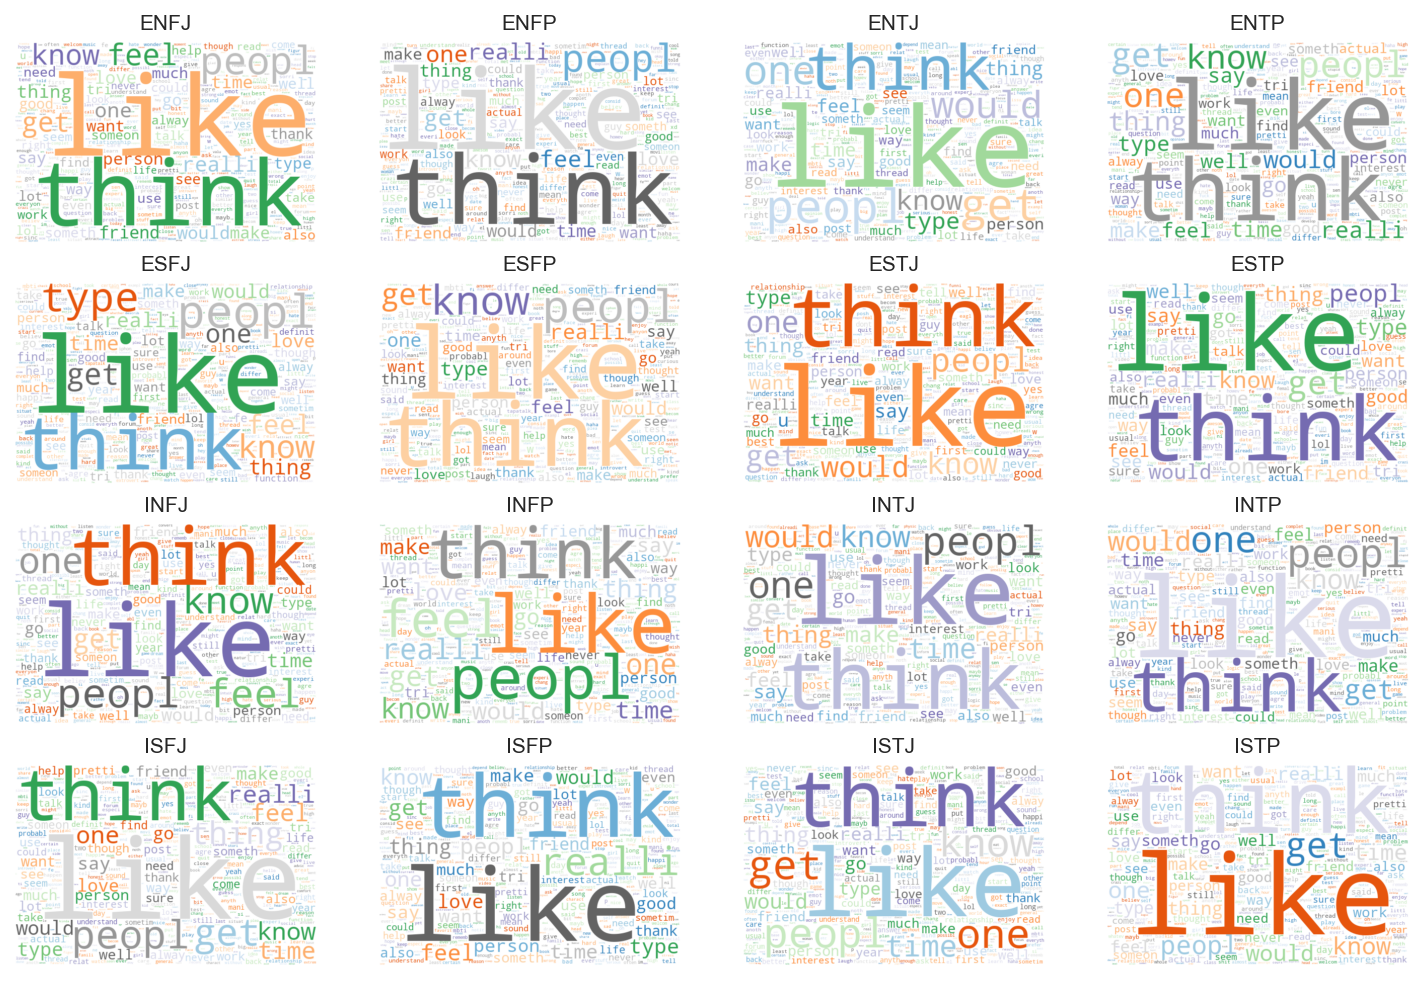

In [24]:
fig = plt.figure(figsize=(12,8), dpi=150)
for idx, mbti in enumerate(multi_type_list):
    ax = fig.add_subplot(4, 4, idx+1)
    freq_dict = getSortFreqDictForText(df_multi_word['flat'][idx])
    wordcloud = createWordCloud(freq_dict)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis('off')
    ax.set_title(mbti, fontsize=10)
fig.show()
fig.savefig('../img/wordcloud_newPre.png')


## 4: Feature engineering

In [17]:
# # Load preprocessed data
# data = pd.read_csv('../data/Kaggle_MBTI_newPre.csv')
# data

### TF-IDF

不設任何限制的 Tf-IDf 會有 78195 個 features

In [25]:
vectorizer = TfidfVectorizer(analyzer="word",
                          max_features=None,
                          lowercase=None,
                          ngram_range=(1,1))
X_tfidf = vectorizer.fit_transform(data['flat'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names())
df_tfidf

aa  aaa  aaaa  aaaaa  aaaaaa  aaaaaaaa  aaaaaaaaa  aaaaaaaaaa  \
0     0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
1     0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
2     0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
3     0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
4     0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
...   ...  ...   ...    ...     ...       ...        ...         ...   
8670  0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
8671  0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
8672  0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
8673  0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   
8674  0.0  0.0   0.0    0.0     0.0       0.0        0.0         0.0   

      aaaaaaaaaaaaaaaaa  aaaaaaaaaaaaaaaaaaaaa  ...  zzward  zzz  zzzquil  \
0                   0.0                    0.0  ...     0.0  0.0      0.0   
1                   0.0                    0.0  ...     0.0  0.0      0.0   
2                   0.0                    0.0  ...     0.0  0.0      0.0   
3                   0.0                    0.0  ...     0.0  0.0      0.0   
4                   0.0                    0.0  ...     0.0  0.0      0.0   
...                 ...                    ...  ...     ...  ...      ...   
8670                0.0                    0.0  ...     0.0  0.0      0.0   
8671                0.0                    0.0  ...     0.0  0.0      0.0   
8672                0.0                    0.0  ...     0.0  0.0      0.0   
8673                0.0                    0.0  ...     0.0  0.0      0.0   
8674                0.0                    0.0  ...     0.0  0.0      0.0   

      zzzvader  zzzz  zzzzero  zzzzz  zzzzzzzz  zzzzzzzzzzz  \
0          0.0   0.0      0.0    0.0       0.0          0.0   
1          0.0   0.0      0.0    0.0       0.0          0.0   
2          0.0   0.0      0.0    0.0       0.0          0.0   
3          0.0   0.0      0.0    0.0       0.0          0.0   
4          0.0   0.0      0.0    0.0       0.0          0.0   
...        ...   ...      ...    ...       ...          ...   
8670       0.0   0.0      0.0    0.0       0.0          0.0   
8671       0.0   0.0      0.0    0.0       0.0          0.0   
8672       0.0   0.0      0.0    0.0       0.0          0.0   
8673       0.0   0.0      0.0    0.0       0.0          0.0   
8674       0.0   0.0      0.0    0.0       0.0          0.0   

      zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz  
0                                 0.0  
1                                 0.0  
2                                 0.0  
3                                 0.0  
4                                 0.0  
...                               ...  
8670                              0.0  
8671                              0.0  
8672                              0.0  
8673                              0.0  
8674                              0.0  

[8675 rows x 68087 columns]

查看 TF-IDF 最高的 50 個 terms

In [27]:
# top 50 words in entire corpus
reverse_dic = {}
for key in vectorizer.vocabulary_:
    reverse_dic[vectorizer.vocabulary_[key]] = key
top_50 = np.asarray(np.argsort(np.sum(X_tfidf, axis=0))[0,-50:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_50]

['like',
 'think',
 'peopl',
 'know',
 'feel',
 'one',
 'get',
 'realli',
 'would',
 'thing',
 'time',
 'type',
 'go',
 'say',
 'love',
 'make',
 'want',
 'person',
 'friend',
 'well',
 'much',
 'way',
 'see',
 'good',
 'tri',
 'someth',
 'lot',
 'also',
 'use',
 'thank',
 'work',
 'alway',
 'even',
 'seem',
 'someon',
 'look',
 'find',
 'life',
 'though',
 'read',
 'year',
 'never',
 'post',
 'could',
 'need',
 'actual',
 'talk',
 'interest',
 'thought',
 'mean']

### TruncatedSVD
計算出 100 個奇異值最大的值

In [29]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
X_svd.shape

(8675, 100)

In [30]:
df_svd = pd.DataFrame(X_svd)
df_svd

0         1         2         3         4         5         6   \
0     0.224794 -0.025650 -0.038669  0.039152  0.037236  0.114450 -0.022400   
1     0.354054  0.013849  0.000777  0.012500 -0.004292  0.030651 -0.064256   
2     0.322909 -0.027342 -0.036528  0.009263  0.011900  0.056918 -0.021731   
3     0.381705  0.145523 -0.021641 -0.003728  0.051593  0.000825  0.017638   
4     0.307495 -0.014693 -0.028432  0.002726  0.080135 -0.031135  0.008167   
...        ...       ...       ...       ...       ...       ...       ...   
8670  0.287356 -0.021930 -0.029435  0.016636  0.036734  0.053782 -0.017283   
8671  0.412642  0.008274 -0.022867  0.008052 -0.015954  0.100324  0.013235   
8672  0.303815 -0.038304 -0.017926  0.015852  0.094477  0.027784  0.017277   
8673  0.507098 -0.002456 -0.046746 -0.012639 -0.003273 -0.014929  0.043866   
8674  0.480809 -0.078923 -0.024480 -0.013762 -0.012043 -0.023268  0.018039   

            7         8         9   ...        90        91        92  \
0    -0.003715  0.011946  0.025973  ... -0.030979 -0.036724  0.012007   
1    -0.046206 -0.012421 -0.025171  ... -0.007878  0.026101  0.009882   
2    -0.034653  0.015011 -0.019232  ... -0.003017 -0.008176  0.034573   
3     0.091262  0.005977 -0.047377  ... -0.027817  0.029255  0.031884   
4     0.012797 -0.093285 -0.030351  ... -0.007831 -0.013140  0.023739   
...        ...       ...       ...  ...       ...       ...       ...   
8670  0.022812 -0.072813  0.006153  ...  0.002196 -0.019510 -0.001464   
8671  0.007212 -0.058044  0.006821  ... -0.058132 -0.030652  0.045391   
8672 -0.010638 -0.035086 -0.074653  ...  0.029935 -0.019199 -0.011448   
8673  0.016685  0.021180 -0.017280  ... -0.024791  0.033910  0.006487   
8674 -0.023474 -0.008673 -0.014911  ... -0.002430  0.047966 -0.008160   

            93        94        95        96        97        98        99  
0    -0.008947 -0.039690 -0.009921 -0.018272  0.020286 -0.004017  0.048278  
1    -0.001145  0.012137 -0.004928 -0.005703 -0.016465  0.007551 -0.007719  
2    -0.024825 -0.007089 -0.026942  0.020844 -0.047612 -0.024824  0.033656  
3    -0.004150  0.020165 -0.019399  0.015684  0.023689 -0.030768 -0.017179  
4    -0.012560  0.002410 -0.031012  0.009461 -0.031272  0.000490 -0.044663  
...        ...       ...       ...       ...       ...       ...       ...  
8670 -0.050886  0.028782 -0.003260 -0.016360 -0.009414  0.023609  0.038190  
8671 -0.000176  0.001870 -0.011758  0.008268 -0.017189  0.057249 -0.009295  
8672  0.000870  0.027591  0.024924  0.000715 -0.020566 -0.044151  0.032383  
8673 -0.028965 -0.050466 -0.005604  0.019504  0.027135  0.001492 -0.042354  
8674 -0.013939  0.006242 -0.035029 -0.031964 -0.016632  0.040420  0.027928  

[8675 rows x 100 columns]

In [31]:
# Store SVD to csv
df_svd.to_csv('../data/Kaggle_MBTI_newPre_X_svd.csv', index=False)

TSNE

In [32]:
X_tsne = TSNE(n_components=3,verbose=1,random_state=42,perplexity=40,metric='cosine').fit_transform(X_svd)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1','TSNE2','TSNE3'])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8675 samples in 0.002s...
[t-SNE] Computed neighbors for 8675 samples in 1.976s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8675
[t-SNE] Computed conditional probabilities for sample 2000 / 8675
[t-SNE] Computed conditional probabilities for sample 3000 / 8675
[t-SNE] Computed conditional probabilities for sample 4000 / 8675
[t-SNE] Computed conditional probabilities for sample 5000 / 8675
[t-SNE] Computed conditional probabilities for sample 6000 / 8675
[t-SNE] Computed conditional probabilities for sample 7000 / 8675
[t-SNE] Computed conditional probabilities for sample 8000 / 8675
[t-SNE] Computed conditional probabilities for sample 8675 / 8675
[t-SNE] Mean sigma: 0.078770
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.189598
[t-SNE] KL divergence after 950 iterations: 3.124184


In [33]:
df_tsne = pd.concat((df_tsne, pd.DataFrame({'type': list(data['type'])})), axis=1)
df_tsne

TSNE1      TSNE2      TSNE3  type
0    -31.395533  -1.961745  22.748842  INFJ
1      1.994751 -23.812626 -30.716982  ENTP
2    -18.311529 -22.741928  24.440363  INTP
3     -8.887488   9.095267 -35.395889  INTJ
4      2.290943  19.785143 -10.065154  ENTJ
...         ...        ...        ...   ...
8670  11.779954  31.200573   3.890590  ISFP
8671 -17.987009 -38.511425   5.543088  ENFP
8672   8.479636  40.455257  -8.064568  INTP
8673 -31.032511 -19.504370   6.435065  INFP
8674   6.776831  -8.040095  13.431357  INFP

[8675 rows x 4 columns]

In [34]:
# Store TSNE to csv
df_tsne.to_csv('../data/Kaggle_MBTI_newPre_X_TSNE.csv', index=False)

In [ ]:
# # Load TSNE
# df_tsne = pd.read_csv('../data/Kaggle_MBTI_X_tsne_removeMBTI.csv')
# df_tsne

### Visualization (TSNE)

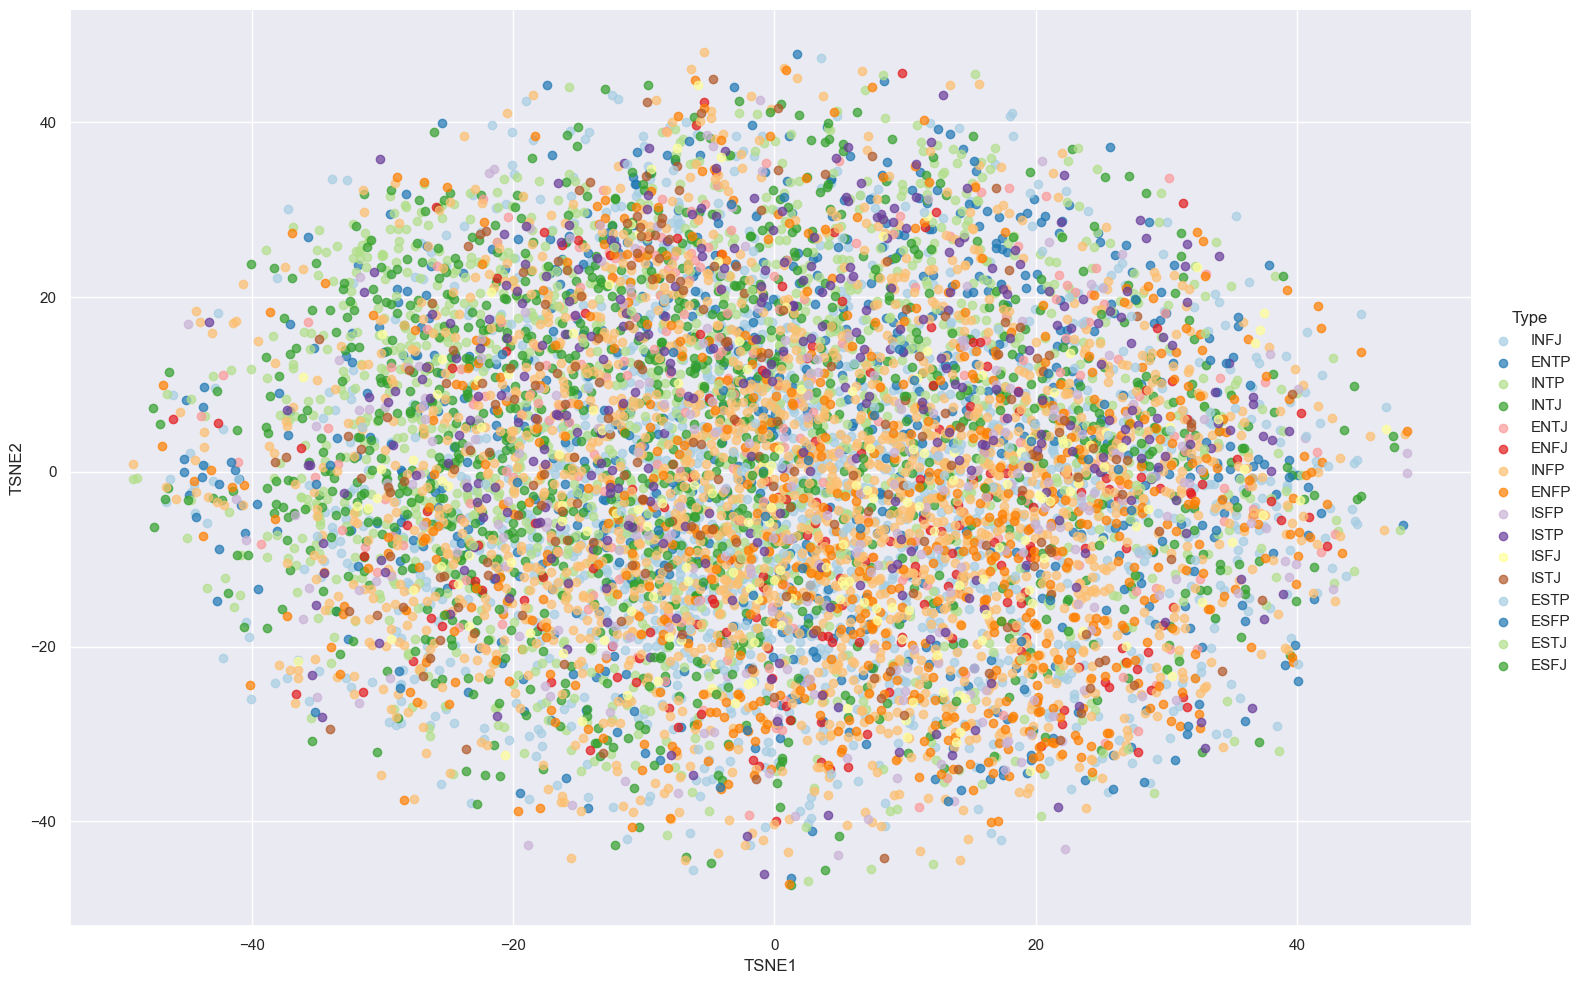

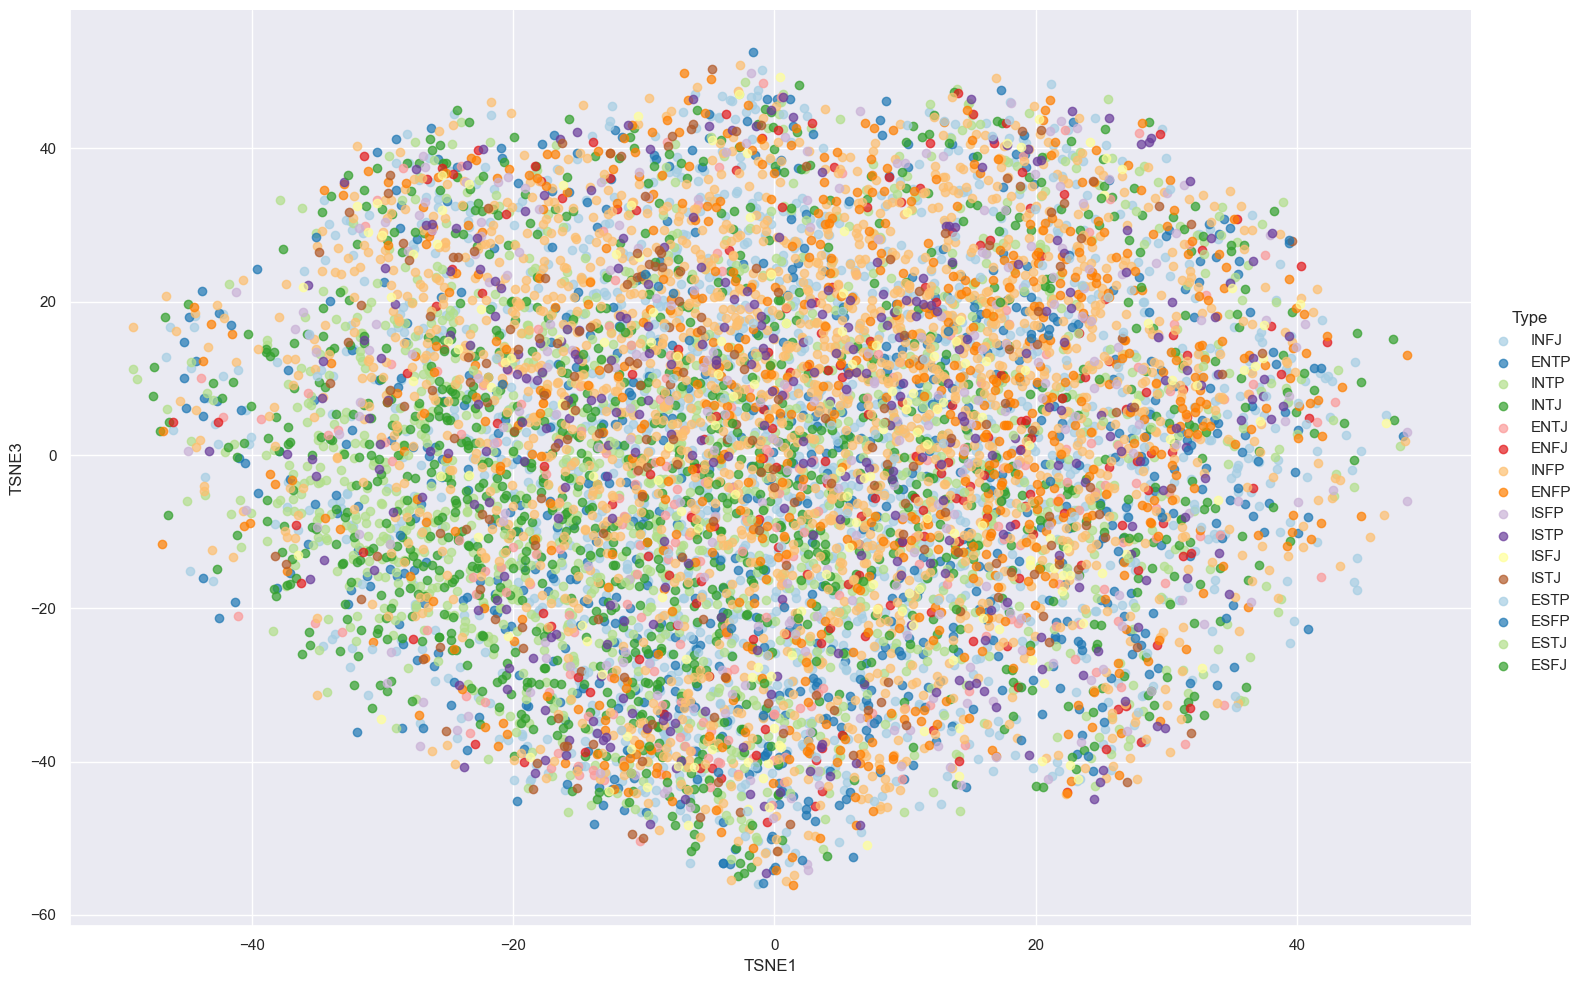

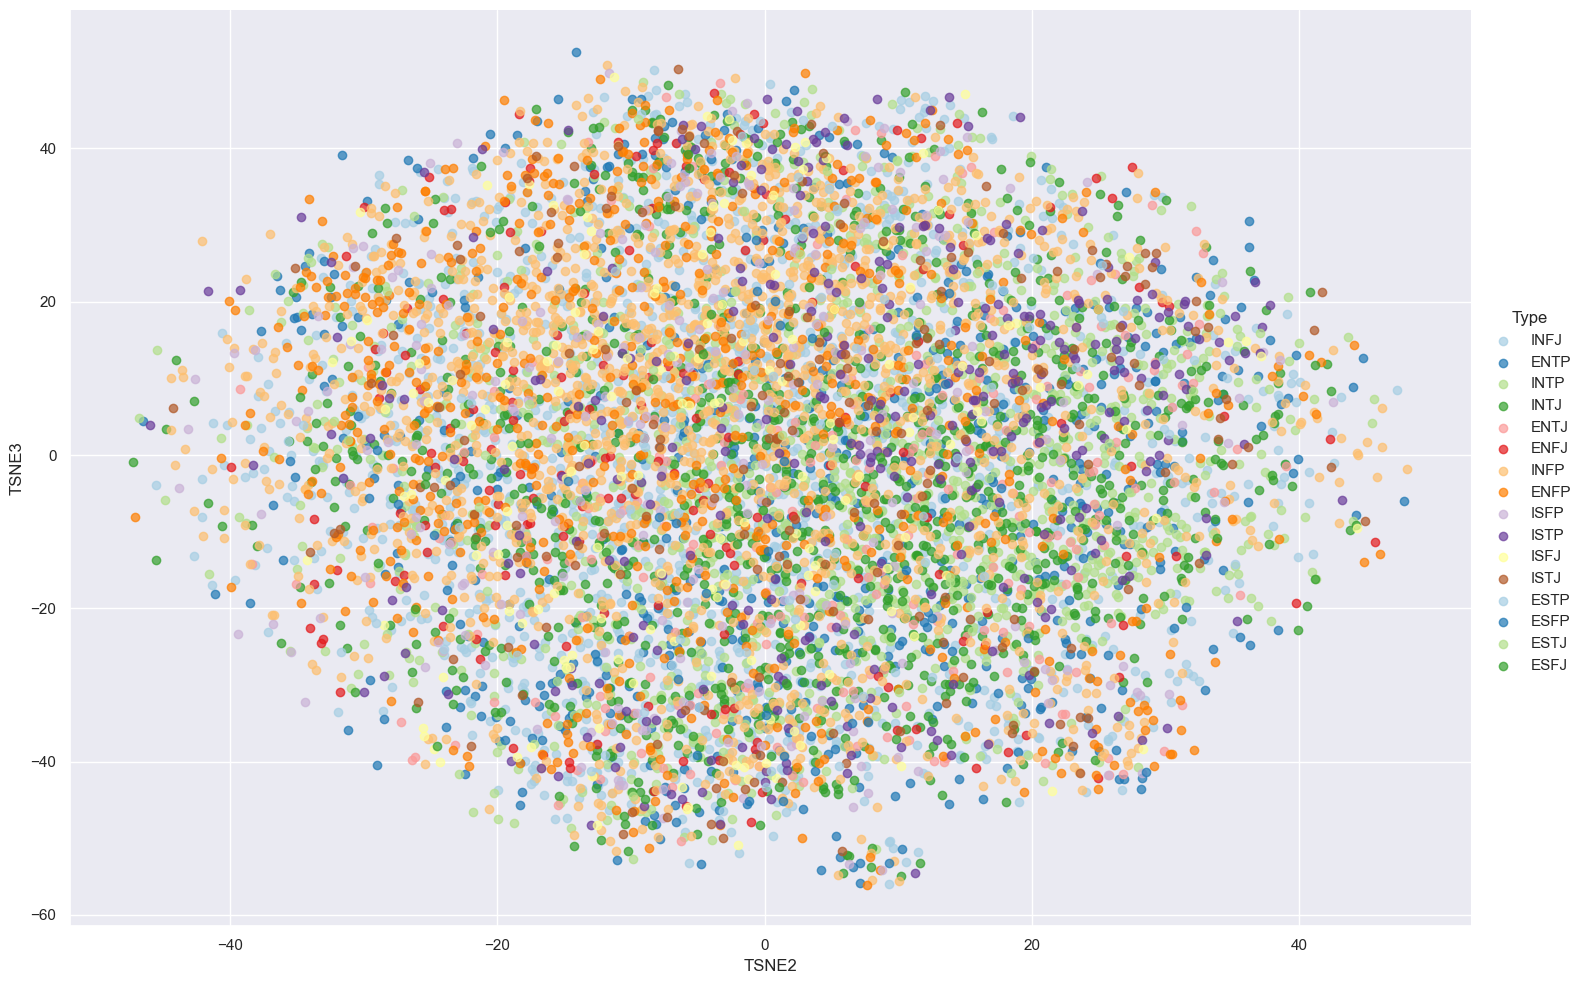

In [35]:
multi_type_list = df_tsne['type'].unique()

# plotting

fig1 = sns.FacetGrid(df_tsne,hue='type',palette='Paired',height=10,aspect=1.5)
fig1.map(plt.scatter, 'TSNE1', 'TSNE2',alpha=0.7)
fig1.add_legend(title='Type', label_order=multi_type_list)
fig1.savefig('../img/TSNE1_newPre.png')

fig2 = sns.FacetGrid(df_tsne,hue='type',palette='Paired',height=10,aspect=1.5)
fig2.map(plt.scatter, 'TSNE1', 'TSNE3',alpha=0.7)
fig2.add_legend(title='Type', label_order=multi_type_list)
fig2.savefig('../img/TSNE2_newPre.png')

fig3 = sns.FacetGrid(df_tsne,hue='type',palette='Paired',height=10,aspect=1.5)
fig3.map(plt.scatter, 'TSNE2', 'TSNE3',alpha=0.7)
fig3.add_legend(title='Type', label_order=multi_type_list)
fig3.savefig('../img/TSNE3_newPre.png')

plt.show()

## Binary Classification

In [36]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data_labeled = data.join(data.apply (lambda row: get_types (row),axis=1))
data_labeled

type                                              posts  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1     ENTP  'I'm finding the lack of me in these posts ver...   
2     INTP  'Good one  _____   https://www.youtube.com/wat...   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4     ENTJ  'You're fired.|||That's another silly misconce...   
...    ...                                                ...   
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...   
8671  ENFP  'So...if this thread already exists someplace ...   
8672  INTP  'So many questions when i do these things.  I ...   
8673  INFP  'I am very conflicted right now when it comes ...   
8674  INFP  'It has been too long since I have been on per...   

                                           preprocessed  \
0     [moment, sportscent, top, ten, play, prank, li...   
1     [find, lack, post, alarm, sex, bore, posit, of...   
2     [good, one, cours, say, know, bless, cur, abso...   
3     [dear, enjoy, convers, day, esoter, gab, natur...   
4     [fire, anoth, silli, misconcept, approach, log...   
...                                                 ...   
8670  [ixfp, alway, think, cat, fi, dom, reason, esp...   
8671  [thread, alreadi, exist, someplac, el, heck, d...   
8672  [mani, question, thing, would, take, purpl, pi...   
8673  [conflict, right, come, want, child, honest, m...   
8674  [long, sinc, personalitycaf, although, seem, c...   

                                                   flat  IE  NS  TF  JP  
0     moment sportscent top ten play prank life chan...   1   1   0   1  
1     find lack post alarm sex bore posit often exam...   0   1   1   0  
2     good one cours say know bless cur absolut posi...   1   1   1   0  
3     dear enjoy convers day esoter gab natur univer...   1   1   1   1  
4     fire anoth silli misconcept approach logic go ...   0   1   1   1  
...                                                 ...  ..  ..  ..  ..  
8670  ixfp alway think cat fi dom reason especi webs...   1   0   0   0  
8671  thread alreadi exist someplac el heck delet on...   0   1   0   0  
8672  mani question thing would take purpl pill pick...   1   1   1   0  
8673  conflict right come want child honest matern i...   1   1   0   0  
8674  long sinc personalitycaf although seem chang o...   1   1   0   0  

[8675 rows x 8 columns]

In [37]:
# Store data with labeled to csv
data_labeled.to_csv('../data/Kaggle_MBTI_newPre_labeled.csv', index=False)

In [30]:
# # Load labeled data
# data_labeled = pd.read_csv('../data/Kaggle_MBTI_newPre_labeled.csv')

In [38]:
# Plotting Classification class vs Frequency plot for IE, NS, TF, JP
I,N,T,J = data_labeled['IE'].value_counts()[0], data_labeled['NS'].value_counts()[0], data_labeled['TF'].value_counts()[0], data_labeled['JP'].value_counts()[0]
E,S,F,P = data_labeled['IE'].value_counts()[1], data_labeled['NS'].value_counts()[1], data_labeled['TF'].value_counts()[1], data_labeled['JP'].value_counts()[1]

dimensions = ['Introversion-Extraversion','Intuition-Sensing','Thinking-Feeling','Judging-Perceiving']
all = len(data_labeled)

fig = go.Figure()
fig.add_trace(go.Bar(name='I,N,T,J', x=dimensions, y=(I,N,T,J), customdata=[I/all,N/all,T/all,J/all], marker=dict(color=px.colors.qualitative.Pastel1[1])))
fig.add_trace(go.Bar(name='E,S,F,P', x=dimensions, y=(E,S,F,P), customdata=[E/all,S/all,F/all,P/all], marker=dict(color=px.colors.qualitative.Pastel1[3])))
fig.update_layout(barmode='group',title_text="Classification class vs Frequency plot", width=800)
fig.update_traces(hovertemplate='Actual: %{value}<br>Percent: %{customdata:,.2f}')
fig.show()

資料有不平衡情況，之後會用 SMOTE 進行 Oversampling

#### 相關係數
An assumption made in our model is that each letter type is independent of other types i.e. A person’s introversion/extroversion is not related to their judgement/perception. Nevertheless, we want to still test them below using a heat map

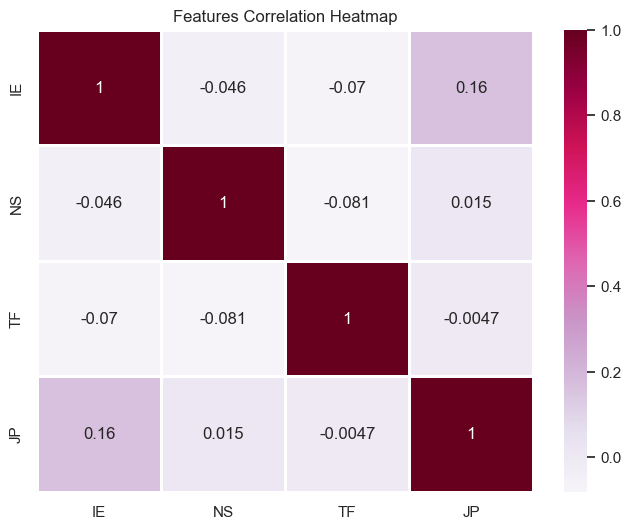

In [39]:
corr = data_labeled[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(8,6))
plt.title('Features Correlation Heatmap', size=12)
sns.heatmap(corr,cmap=plt.cm.PuRd,annot=True,linewidths=1)
plt.show()

#### Training and Testing Split

Only executive one time.

In [79]:
# Train test split
X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = train_test_split(X_svd, data_labeled['IE'], test_size=0.2, random_state=42, stratify=data_labeled['IE'])
X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = train_test_split(X_svd, data_labeled['NS'], test_size=0.2, random_state=42, stratify=data_labeled['NS'])
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = train_test_split(X_svd, data_labeled['TF'], test_size=0.2, random_state=42, stratify=data_labeled['TF'])
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = train_test_split(X_svd, data_labeled['JP'], test_size=0.2, random_state=42, stratify=data_labeled['JP'])

# Store binary dataset to pickle
import pickle

IE_dataset = {"X_train": X_train_IE, "X_test": X_test_IE, "Y_train": Y_train_IE, "Y_test": Y_test_IE}
NS_dataset = {"X_train": X_train_NS, "X_test": X_test_NS, "Y_train": Y_train_NS, "Y_test": Y_test_NS}
TF_dataset = {"X_train": X_train_TF, "X_test": X_test_TF, "Y_train": Y_train_TF, "Y_test": Y_test_TF}
JP_dataset = {"X_train": X_train_JP, "X_test": X_test_JP, "Y_train": Y_train_JP, "Y_test": Y_test_JP}

with open('../data/Kaggle_MBTI_newPre_IE.pickle', 'wb') as file:
    pickle.dump(IE_dataset, file)
with open('../data/Kaggle_MBTI_newPre_NS.pickle', 'wb') as file:
    pickle.dump(NS_dataset, file)
with open('../data/Kaggle_MBTI_newPre_TF.pickle', 'wb') as file:
    pickle.dump(TF_dataset, file)
with open('../data/Kaggle_MBTI_newPre_JP.pickle', 'wb') as file:
    pickle.dump(JP_dataset, file)

In [41]:
# Load dataset form pickle
data_IE = pd.read_pickle('../data/Kaggle_MBTI_newPre_IE.pickle')
data_NS = pd.read_pickle('../data/Kaggle_MBTI_newPre_NS.pickle')
data_TF = pd.read_pickle('../data/Kaggle_MBTI_newPre_TF.pickle')
data_JP = pd.read_pickle('../data/Kaggle_MBTI_newPre_JP.pickle')

X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = data_IE['X_train'], data_IE['X_test'], data_IE['Y_train'], data_IE['Y_test']
X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = data_NS['X_train'], data_NS['X_test'], data_NS['Y_train'], data_NS['Y_test']
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = data_TF['X_train'], data_TF['X_test'], data_TF['Y_train'], data_TF['Y_test']
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = data_JP['X_train'], data_JP['X_test'], data_JP['Y_train'], data_JP['Y_test']

In [42]:
print(f'IE dataset:\nTrain|| X:{X_train_IE.shape}\tY:{Y_train_IE.shape} \nTest || X:{X_test_IE.shape}\tY:{Y_test_IE.shape}\n')
print(f'NS dataset:\nTrain|| X:{X_train_NS.shape}\tY:{Y_train_NS.shape} \nTest || X:{X_test_NS.shape}\tY:{Y_test_NS.shape}\n')
print(f'TF dataset:\nTrain|| X:{X_train_TF.shape}\tY:{Y_train_TF.shape} \nTest || X:{X_test_TF.shape}\tY:{Y_test_TF.shape}\n')
print(f'JP dataset:\nTrain|| X:{X_train_JP.shape}\tY:{Y_train_JP.shape} \nTest || X:{X_test_JP.shape}\tY:{Y_test_JP.shape}\n')

IE dataset:
Train|| X:(6940, 100)	Y:(6940,) 
Test || X:(1735, 100)	Y:(1735,)

NS dataset:
Train|| X:(6940, 100)	Y:(6940,) 
Test || X:(1735, 100)	Y:(1735,)

TF dataset:
Train|| X:(6940, 100)	Y:(6940,) 
Test || X:(1735, 100)	Y:(1735,)

JP dataset:
Train|| X:(6940, 100)	Y:(6940,) 
Test || X:(1735, 100)	Y:(1735,)



### Oversampling with SMOTE

In [43]:
# Generate SMOTE data from original
X_smote_IE, Y_smote_IE = SMOTE(random_state=42).fit_resample(X_train_IE, Y_train_IE)
X_smote_NS, Y_smote_NS = SMOTE(random_state=42).fit_resample(X_train_NS, Y_train_NS)

In [44]:
# Store SMOTE dataset to pickle
import pickle

IE_smote = {"X_train": X_smote_IE, "Y_train": Y_smote_IE}
NS_smote = {"X_train": X_smote_NS, "Y_train": Y_smote_NS}

with open('../data/Kaggle_MBTI_newPre_IE_smote.pickle', 'wb') as file:
    pickle.dump(IE_smote, file)
with open('../data/Kaggle_MBTI_newPre_NS_smote.pickle', 'wb') as file:
    pickle.dump(NS_smote, file)

In [4]:
# # Load SMOTE form pickle
# data_IE_smote = pd.read_pickle('../data/Kaggle_MBTI_newPre_IE_smote.pickle')
# data_NS_smote = pd.read_pickle('../data/Kaggle_MBTI_newPre_NS_smote.pickle')

# X_smote_IE, Y_smote_IE = data_IE_smote['X_train'], data_IE_smote['Y_train']
# X_smote_NS, Y_smote_NS = data_NS_smote['X_train'], data_NS_smote['Y_train']

#### Model method

In [45]:
def predict(model1, model2, model3, model4):
    '''
    Function to predict labels for X_test of the given model
    Input: 4 models
    Output: predicted values
    '''
    ypredIE = model1.fit(X_train_IE,Y_train_IE).best_estimator_.predict(X_test_IE)
    ypredNS = model2.fit(X_train_NS,Y_train_NS).best_estimator_.predict(X_test_NS)
    ypredTF = model3.fit(X_train_TF,Y_train_TF).best_estimator_.predict(X_test_TF)
    ypredJP = model4.fit(X_train_JP,Y_train_JP).best_estimator_.predict(X_test_JP)

    return ypredIE, ypredNS, ypredTF, ypredJP


def predict_SMOTE(model1, model2, model3, model4):
    '''
    Function to predict labels for X_test of the given model
    Input: 4 models
    Output: predicted values
    '''
    ypredIE = model1.fit(X_smote_IE,Y_smote_IE).best_estimator_.predict(X_test_IE)
    ypredNS = model2.fit(X_smote_NS,Y_smote_NS).best_estimator_.predict(X_test_NS)
    ypredTF = model3.fit(X_train_TF,Y_train_TF).best_estimator_.predict(X_test_TF)
    ypredJP = model4.fit(X_train_JP,Y_train_JP).best_estimator_.predict(X_test_JP)

    return ypredIE, ypredNS, ypredTF, ypredJP

#### Evaluation method

In [47]:
def print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP):
   '''
   Function to print Classification Report of the given model
   This function takes 4 predicted output datasets as input.
   It computes classfication report: accuracy, recall, f1-score.
   It prints classification reports for all 4 predictions (models).
   '''
   print(f'Classification Report for Introversion(I) / Extroversion(E):\n {classification_report(Y_test_IE, ypredIE)}\n')
   
   print(f'Classification Report for Intuition(N) / Sensing(S):\n {classification_report(Y_test_NS, ypredNS)}\n')
   
   print(f'Classification Report for Thinking(T) / Feeling(F):\n{classification_report(Y_test_TF, ypredTF)}\n')

   print(f'Classification Report for Judging(J) / Perceiving(P):\n {classification_report(Y_test_JP, ypredJP)}\n')


def print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP):
   cm = confusion_matrix(Y_test_IE, ypredIE)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Reds_r',fmt='g')
   plt.ylabel('Y_test_IE')
   plt.xlabel('ypredIE')
   plt.title('Confusion matrix for Introversion(I) / Extroversion(E): ', size=12)

   cm = confusion_matrix(Y_test_NS, ypredNS)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Greens_r',fmt='g')
   plt.ylabel('Y_test_NS')
   plt.xlabel('ypredNS')
   plt.title('Confusion matrix for Intuition(N) / Sensing(S): ', size=12)

   cm = confusion_matrix(Y_test_TF, ypredTF)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Blues_r',fmt='g')
   plt.ylabel('Y_test_TF')
   plt.xlabel('ypredTF')
   plt.title('Confusion matrix for Thinking(T) / Feeling(F): ', size=12)

   cm = confusion_matrix(Y_test_JP, ypredJP)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Purples_r',fmt='g')
   plt.ylabel('Y_test_JP')
   plt.xlabel('ypredJP')
   plt.title('Confusion matrix for Judging(J) / Perceiving(P): ', size=12)


def print_roc_auc_curve(probIE, probNS, probTF, probJP, title:str):
   fp_IE, tp_IE, _ = roc_curve(Y_test_IE, probIE[:,1])
   fp_NS, tp_NS, _ = roc_curve(Y_test_NS, probNS[:,1])
   fp_TF, tp_TF, _ = roc_curve(Y_test_TF, probTF[:,1])
   fp_JP, tp_JP, _ = roc_curve(Y_test_JP, probJP[:,1])
   plt.figure(figsize=(8,5))
   plt.plot(fp_IE, tp_IE, linestyle=':', color='indianred', label=f'Introversion(I) / Extroversion(E) (area={auc(fp_IE, tp_IE):.2f})',linewidth=1.8)
   plt.plot(fp_NS, tp_NS, linestyle='--', color='darkseagreen', label=f'Intuition(N) / Sensing(S) (area={auc(fp_NS, tp_NS):.2f})',linewidth=1.8)
   plt.plot(fp_TF, tp_TF, linestyle='-.', color='dodgerblue', label=f'Thinking(T) / Feeling(F) (area={auc(fp_TF, tp_TF):.2f})',linewidth=1.8)
   plt.plot(fp_JP, tp_JP, linestyle='--', color='orchid', label=f'Judging(J) / Perceiving(P) (area={auc(fp_TF, tp_TF):.2f})',linewidth=1.8)
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title(title+' ROC Curve')
   plt.legend(loc='best')
   plt.savefig('../img/ROC_newPre_'+title+'.png')

### Imbalance data

#### Naive Bayes Model

In [52]:
gNB = GaussianNB()
# Cross validation
grid1 = GridSearchCV(gNB,{},cv=5)
grid2 = GridSearchCV(gNB,{},cv=5)
grid3 = GridSearchCV(gNB,{},cv=5)
grid4 = GridSearchCV(gNB,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.40      0.23      0.29       400
           1       0.80      0.90      0.84      1335

    accuracy                           0.74      1735
   macro avg       0.60      0.56      0.57      1735
weighted avg       0.70      0.74      0.72      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.23      0.18      0.20       239
           1       0.87      0.91      0.89      1496

    accuracy                           0.81      1735
   macro avg       0.55      0.54      0.54      1735
weighted avg       0.78      0.81      0.79      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       939
           1       0.62      0.75      0.68       796

    accuracy

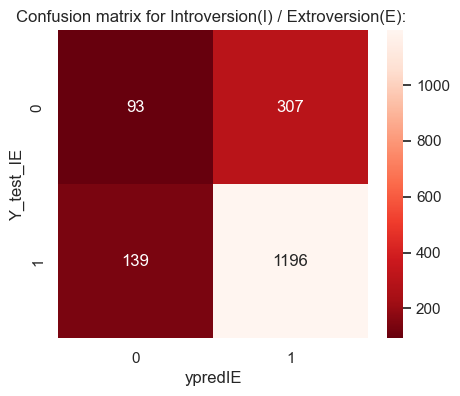

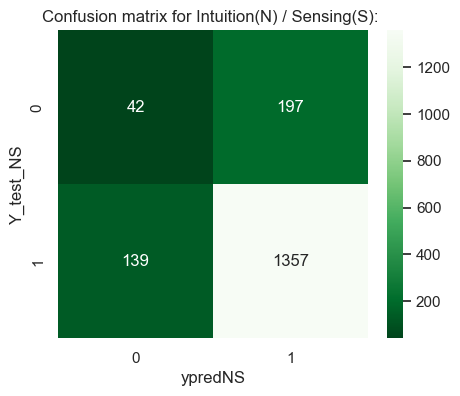

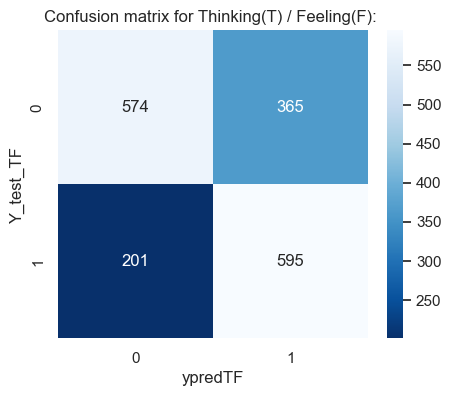

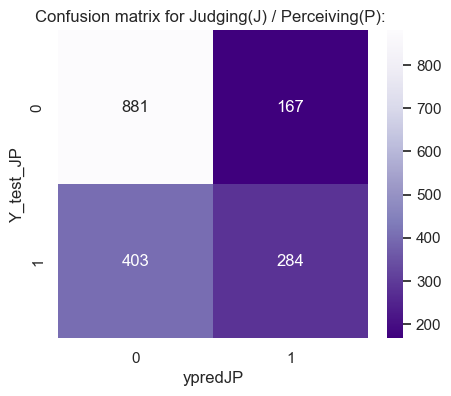

In [53]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

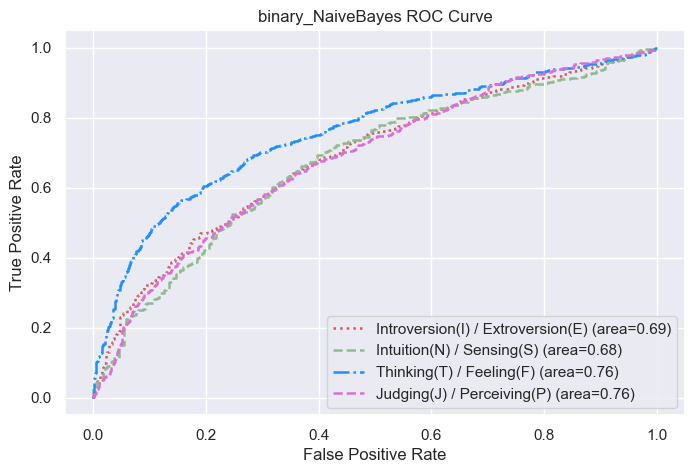

In [54]:
# ROC curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF),grid4.best_estimator_.predict_proba(X_test_JP),
                    title='binary_NaiveBayes')

#### Logistic Regression

In [59]:
log = LogisticRegression(random_state=42,max_iter=500)
# Cross validation
grid1 = GridSearchCV(log,{},cv=5)
grid2 = GridSearchCV(log,{},cv=5)
grid3 = GridSearchCV(log,{},cv=5)
grid4 = GridSearchCV(log,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.74      0.07      0.12       400
           1       0.78      0.99      0.87      1335

    accuracy                           0.78      1735
   macro avg       0.76      0.53      0.50      1735
weighted avg       0.77      0.78      0.70      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       239
           1       0.86      1.00      0.93      1496

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.74      0.86      0.80      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       939
           1       0.77      0.77      0.77       796

    accuracy

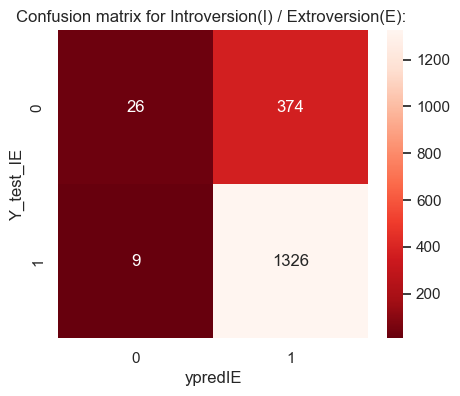

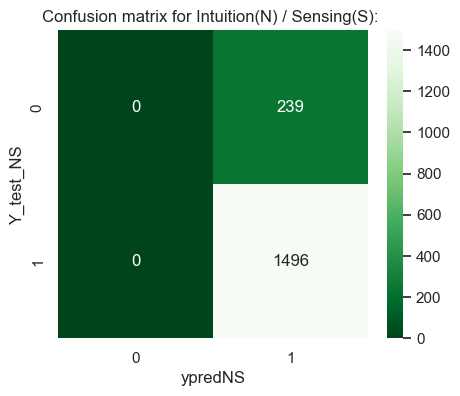

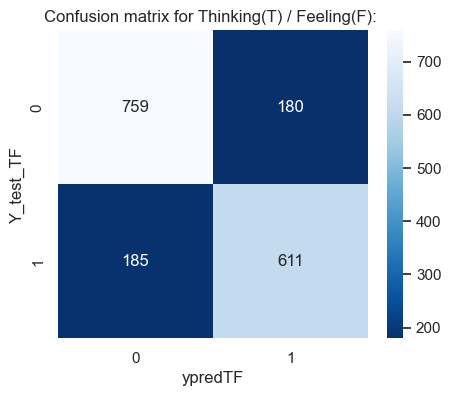

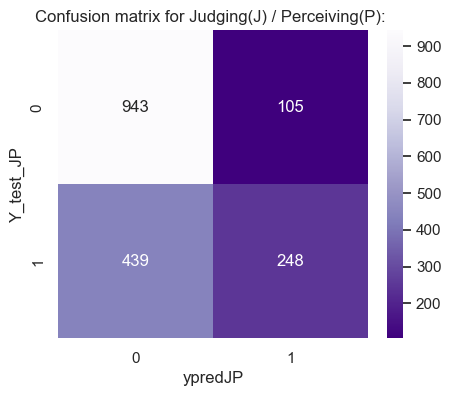

In [60]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

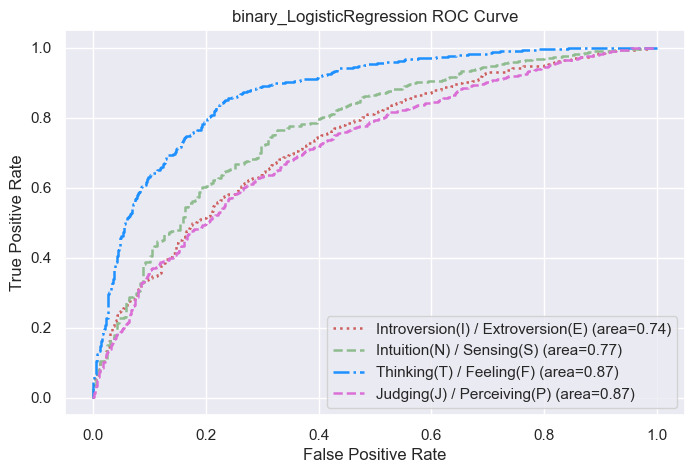

In [61]:
# ROC curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF),grid4.best_estimator_.predict_proba(X_test_JP),
                    title='binary_LogisticRegression')

#### SVM

In [62]:
svm = SVC(random_state=42, probability=True)
# param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
# Cross validation
grid1 = GridSearchCV(svm,{},cv=5)
grid2 = GridSearchCV(svm,{},cv=5)
grid3 = GridSearchCV(svm,{},cv=5)
grid4 = GridSearchCV(svm,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.50      0.00      0.00       400
           1       0.77      1.00      0.87      1335

    accuracy                           0.77      1735
   macro avg       0.63      0.50      0.44      1735
weighted avg       0.71      0.77      0.67      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       239
           1       0.86      1.00      0.93      1496

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.74      0.86      0.80      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       939
           1       0.77      0.79      0.78       796

    accuracy

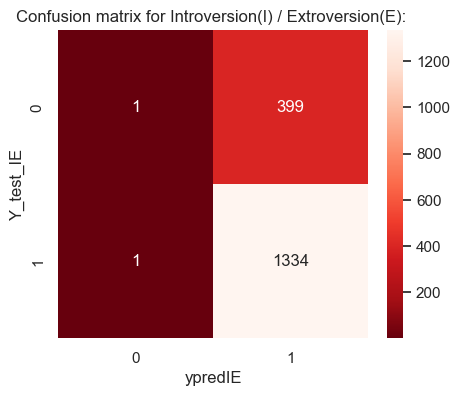

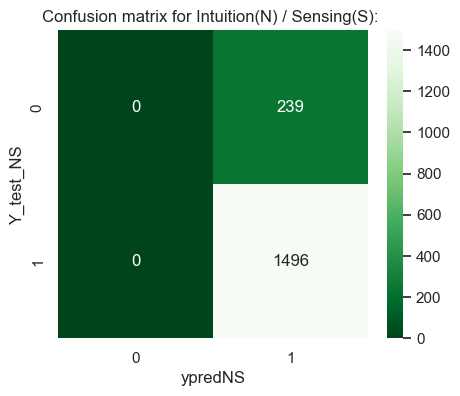

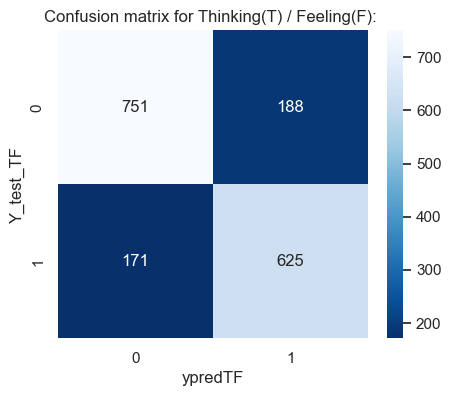

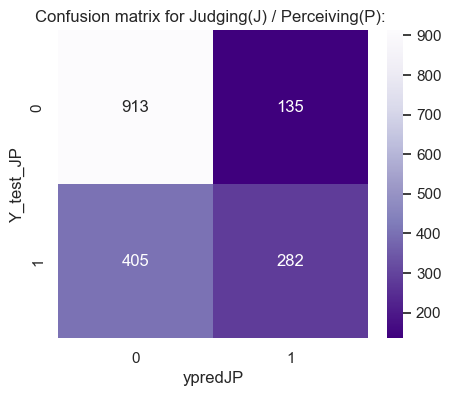

In [63]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

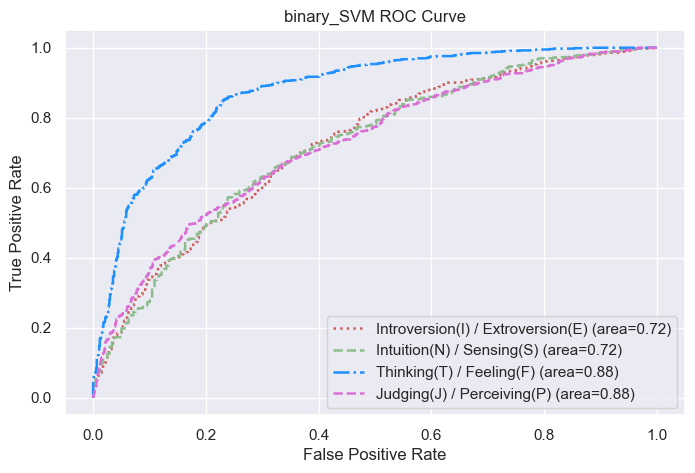

In [64]:
# ROC curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF),grid4.best_estimator_.predict_proba(X_test_JP),
                    title='binary_SVM')

#### K-Nearest Neighbor (KNN)

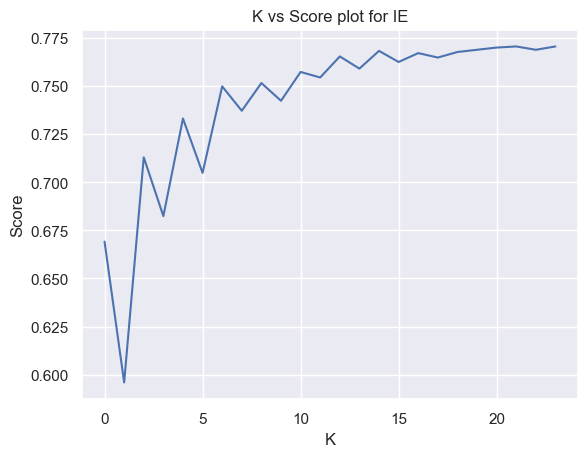

Maximum Accuracy of 0.7706051873198847 at k=22


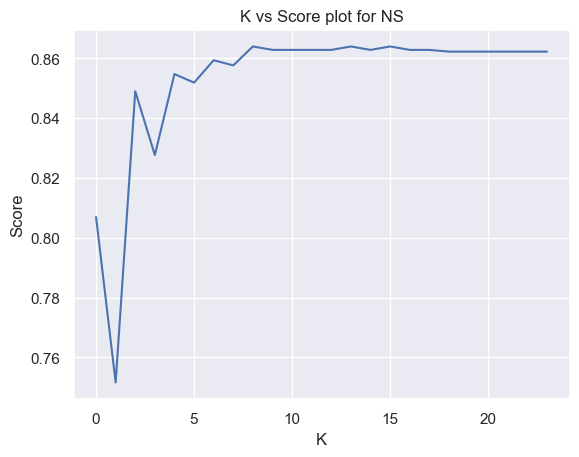

Maximum Accuracy of 0.8639769452449567 at k=9


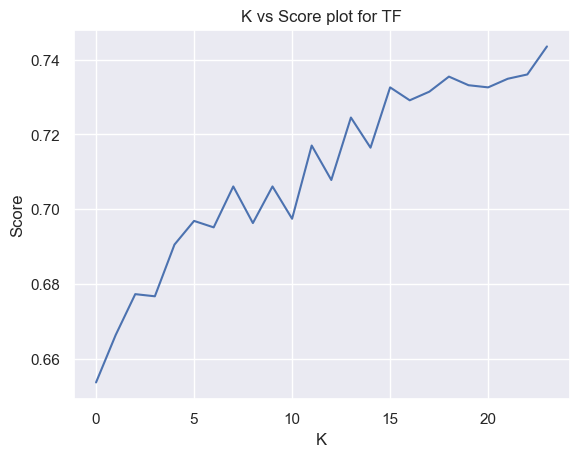

Maximum Accuracy of 0.7435158501440923 at k=24


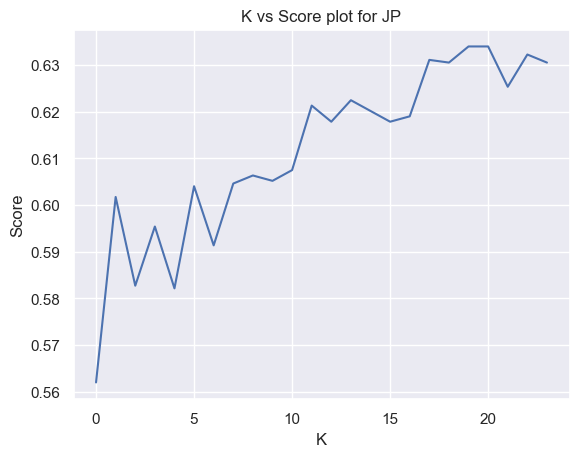

Maximum Accuracy of 0.7435158501440923 at k=24


In [65]:
def plot_graph(val,xlab,ylab,title):
    plt.figure()
    plt.plot(val)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,25):
    k1 = KNeighborsClassifier(n_neighbors=i)
    k1.fit(X_train_IE, Y_train_IE)
    k1_score.append(k1.score(X_test_IE, Y_test_IE))

df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'K','Score','K vs Score plot for IE')
print(f'Maximum Accuracy of {df1.max()[0]} at k={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,25):
	k2 = KNeighborsClassifier(n_neighbors=i)
	k2.fit(X_train_NS, Y_train_NS)
	k2_score.append(k2.score(X_test_NS, Y_test_NS))

df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'K','Score','K vs Score plot for NS')
print(f'Maximum Accuracy of {df2.max()[0]} at k={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,25):
  k3 = KNeighborsClassifier(n_neighbors=i)
  k3.fit(X_train_TF, Y_train_TF)
  k3_score.append(k3.score(X_test_TF, Y_test_TF))

df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'K','Score','K vs Score plot for TF')
print(f'Maximum Accuracy of {df3.max()[0]} at k={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,25):
  k4 = KNeighborsClassifier(n_neighbors=i)
  k4.fit(X_train_JP, Y_train_JP)
  k4_score.append(k4.score(X_test_JP, Y_test_JP))

df4 = pd.DataFrame(k3_score,columns=['JP'])
plot_graph(k4_score,'K','Score','K vs Score plot for JP')
print(f'Maximum Accuracy of {df4.max()[0]} at k={df4.idxmax()[0]+1}')

In [66]:
kbest = KNeighborsClassifier(n_neighbors=df1.idxmax()[0]+1)
ypredIE = kbest.fit(X_train_IE,Y_train_IE).predict(X_test_IE)
probIE = kbest.predict_proba(X_test_IE)

kbest = KNeighborsClassifier(n_neighbors=df2.idxmax()[0]+1)
ypredNS = kbest.fit(X_train_NS,Y_train_NS).predict(X_test_NS)
probNS = kbest.predict_proba(X_test_NS)

kbest = KNeighborsClassifier(n_neighbors=df3.idxmax()[0]+1)
ypredTF = kbest.fit(X_train_TF,Y_train_TF).predict(X_test_TF)
probTF = kbest.predict_proba(X_test_TF)

kbest = KNeighborsClassifier(n_neighbors=df4.idxmax()[0]+1)
ypredJP = kbest.fit(X_train_JP,Y_train_JP).predict(X_test_JP)
probJP = kbest.predict_proba(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.53      0.04      0.08       400
           1       0.78      0.99      0.87      1335

    accuracy                           0.77      1735
   macro avg       0.65      0.52      0.48      1735
weighted avg       0.72      0.77      0.69      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.67      0.03      0.05       239
           1       0.87      1.00      0.93      1496

    accuracy                           0.86      1735
   macro avg       0.77      0.51      0.49      1735
weighted avg       0.84      0.86      0.81      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       939
           1       0.71      0.74      0.73       796

    accuracy

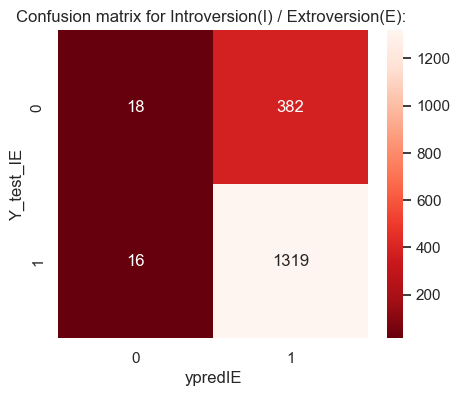

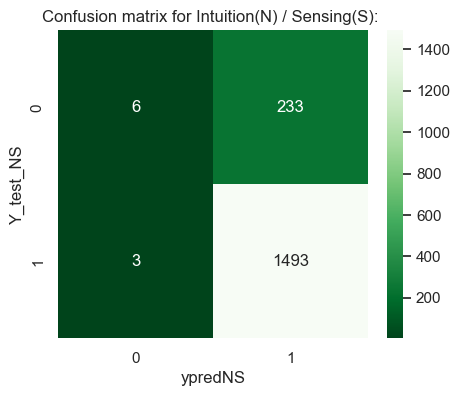

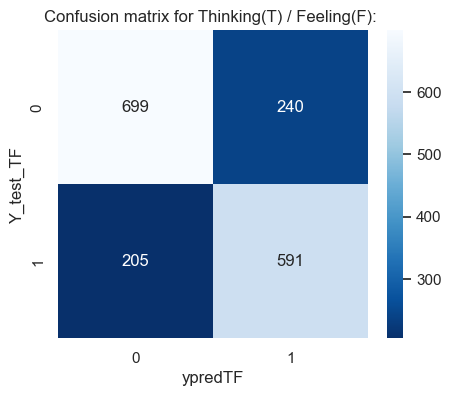

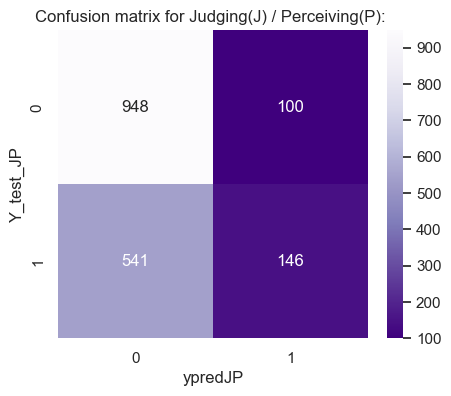

In [67]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

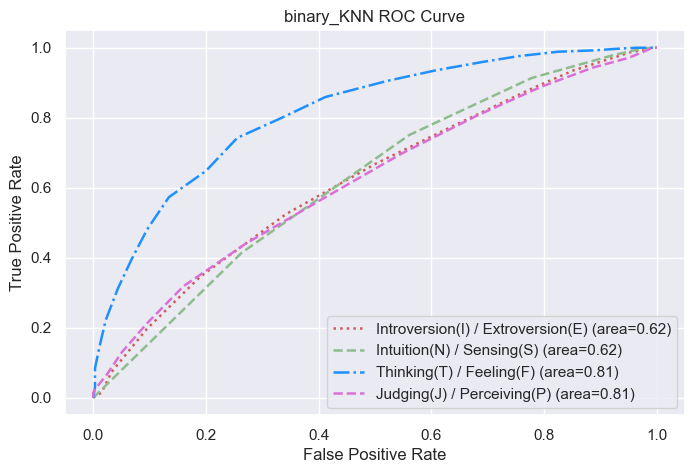

In [68]:
# ROC curve
print_roc_auc_curve(probIE, probNS, probTF, probJP, title='binary_KNN')

#### Decision Tree

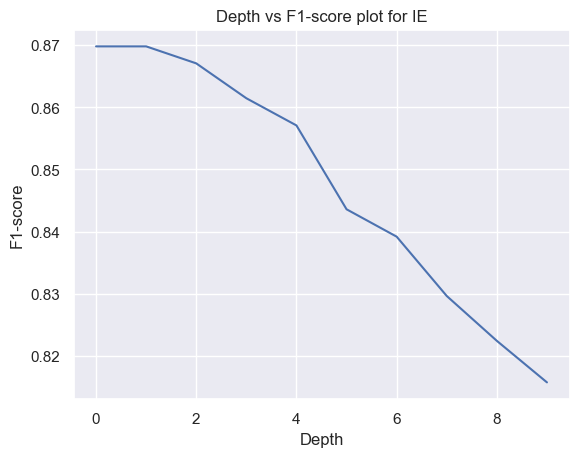

Maximum F1-score of 0.8697988463460776 at depth=1


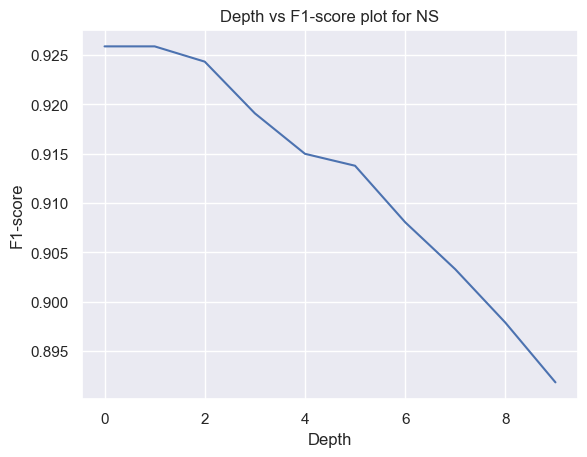

Maximum F1-score of 0.9258628309310083 at depth=1


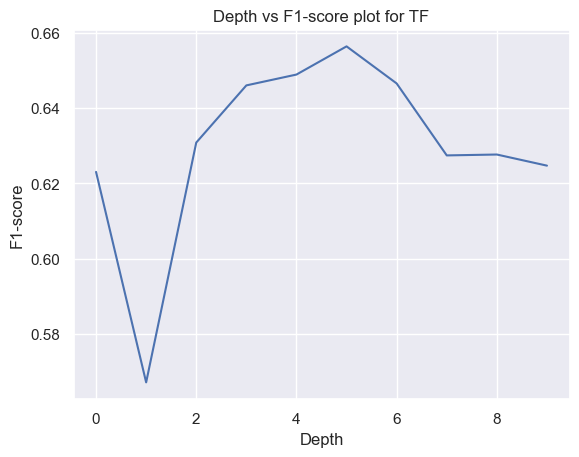

Maximum F1-score of 0.6563498835776219 at depth=6


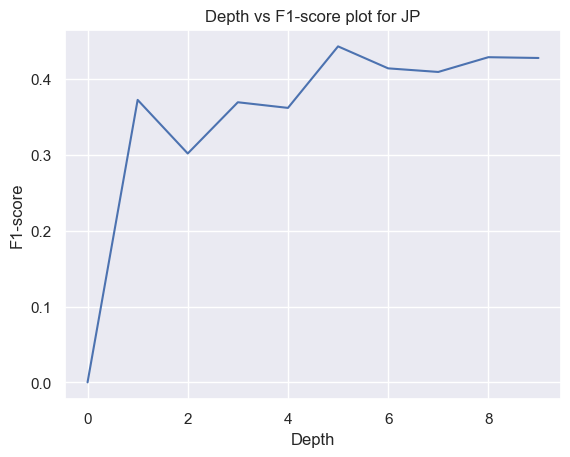

Maximum F1-score of 0.44288402814691097 at depth=6


In [69]:
def plot_graph(val, title):
    plt.plot(val)
    plt.ylabel('F1-score')
    plt.xlabel('Depth')
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,11):
    k1_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k1_cart, X_train_IE, Y_train_IE, cv=5, scoring='f1')
    k1_score.append(score.mean())
df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'Depth vs F1-score plot for IE')
print(f'Maximum F1-score of {df1.max()[0]} at depth={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,11):
    k2_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k2_cart, X_train_NS, Y_train_NS, cv=5, scoring='f1')
    k2_score.append(score.mean())
df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'Depth vs F1-score plot for NS')
print(f'Maximum F1-score of {df2.max()[0]} at depth={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,11):
    k3_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k3_cart, X_train_TF, Y_train_TF, cv=5, scoring='f1')
    k3_score.append(score.mean())
df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'Depth vs F1-score plot for TF')
print(f'Maximum F1-score of {df3.max()[0]} at depth={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,11):
    k4_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k4_cart, X_train_JP, Y_train_JP, cv=5, scoring='f1')
    k4_score.append(score.mean())
df4 = pd.DataFrame(k4_score,columns=['JP'])
plot_graph(k4_score,'Depth vs F1-score plot for JP')
print(f'Maximum F1-score of {df4.max()[0]} at depth={df4.idxmax()[0]+1}')

In [70]:
dtbest = DecisionTreeClassifier(criterion="gini", max_depth=df1.idxmax()[0]+1, random_state=42)
ypredIE = dtbest.fit(X_train_IE,Y_train_IE).predict(X_test_IE)
probIE = dtbest.predict_proba(X_test_IE)

dtbest = DecisionTreeClassifier(criterion="gini", max_depth=df2.idxmax()[0]+1, random_state=42)
ypredNS = dtbest.fit(X_train_NS,Y_train_NS).predict(X_test_NS)
probNS = dtbest.predict_proba(X_test_NS)

dtbest = DecisionTreeClassifier(criterion="gini", max_depth=df3.idxmax()[0]+1, random_state=42)
ypredTF = dtbest.fit(X_train_TF,Y_train_TF).predict(X_test_TF)
probTF = dtbest.predict_proba(X_test_TF)

dtbest = DecisionTreeClassifier(criterion="gini", max_depth=df4.idxmax()[0]+1, random_state=42)
ypredJP = dtbest.fit(X_train_JP,Y_train_JP).predict(X_test_JP)
probJP = dtbest.predict_proba(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.77      1.00      0.87      1335

    accuracy                           0.77      1735
   macro avg       0.38      0.50      0.43      1735
weighted avg       0.59      0.77      0.67      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       239
           1       0.86      1.00      0.93      1496

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.74      0.86      0.80      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       939
           1       0.68      0.60      0.64       796

    accuracy

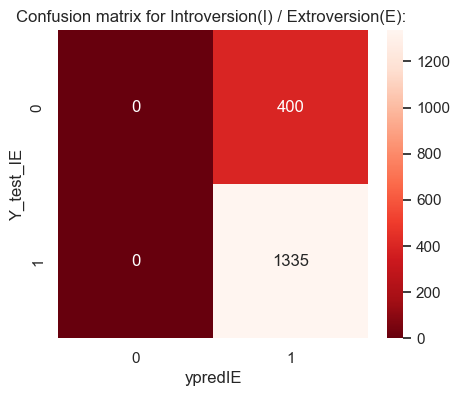

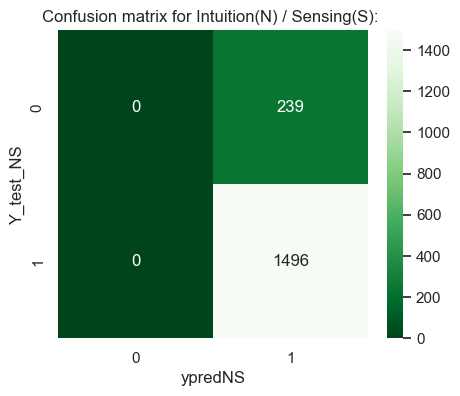

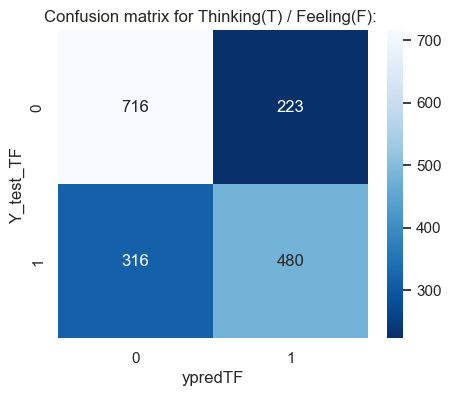

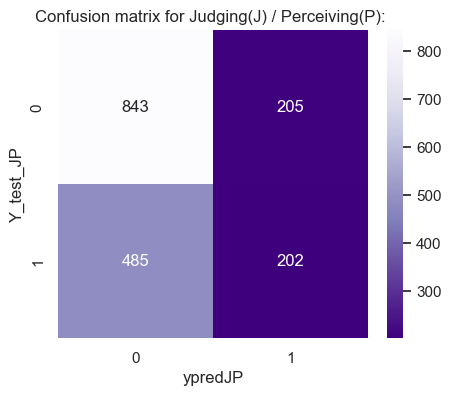

In [71]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

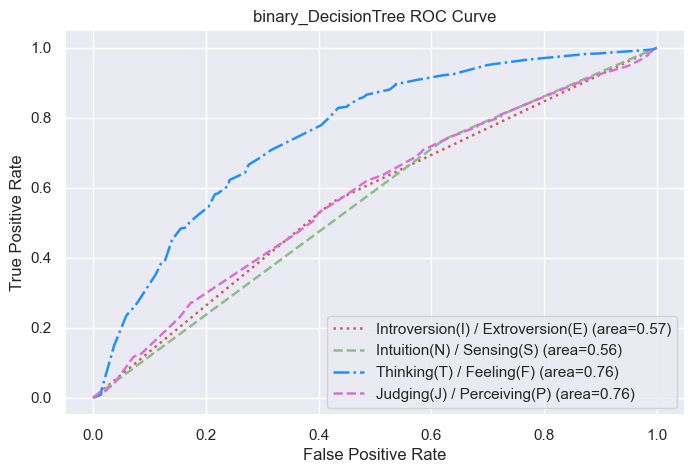

In [72]:
# ROC curve
print_roc_auc_curve(probIE, probNS, probTF, probJP, title='binary_DecisionTree')

#### Random Forest

In [73]:
rf = RandomForestClassifier(n_estimators=200,  # amount of decision tree
                            random_state=42)
# param_grid = {'criterion':["gini", "entropy", "log_loss"]}
# Cross validation
grid1 = GridSearchCV(rf,{},cv=5)
grid2 = GridSearchCV(rf,{},cv=5)
grid3 = GridSearchCV(rf,{},cv=5)
grid4 = GridSearchCV(rf,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.77      1.00      0.87      1335

    accuracy                           0.77      1735
   macro avg       0.38      0.50      0.43      1735
weighted avg       0.59      0.77      0.67      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       239
           1       0.86      1.00      0.93      1496

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.74      0.86      0.80      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       939
           1       0.77      0.65      0.71       796

    accuracy

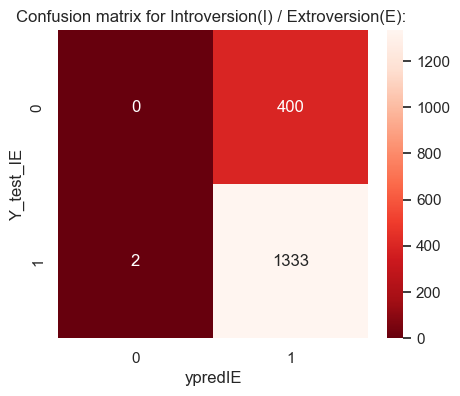

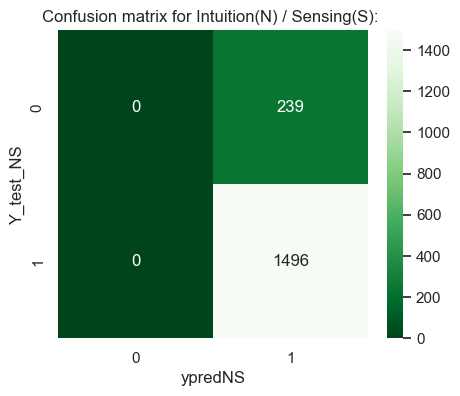

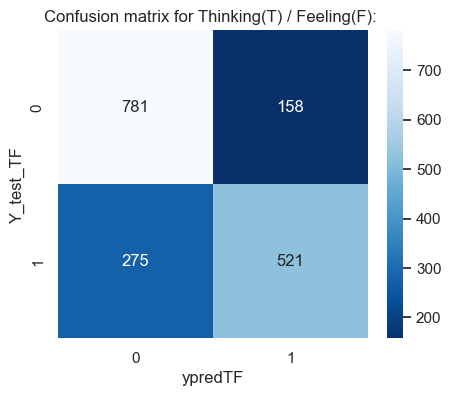

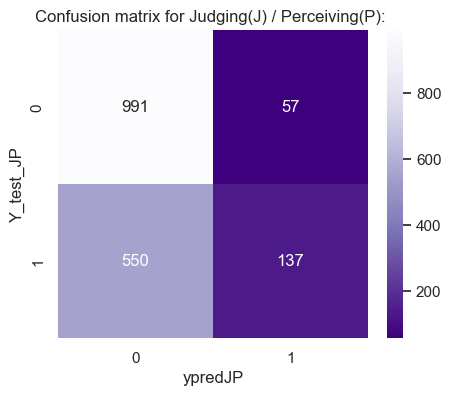

In [74]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

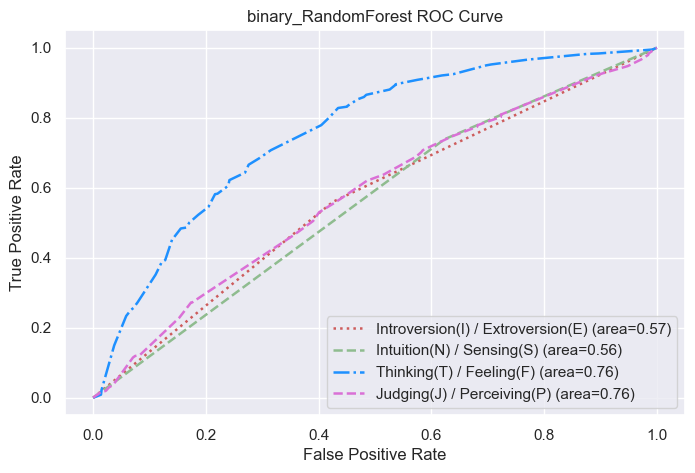

In [75]:
# ROC curve
print_roc_auc_curve(probIE, probNS, probTF, probJP, title='binary_RandomForest')

#### Gradient Boost

In [76]:
boost = GradientBoostingClassifier(random_state=42)
# param_grid = {'criterion':['friedman_mse', 'squared_error', 'mse']}
# Cross validation
grid1 = GridSearchCV(boost,{},cv=5)
grid2 = GridSearchCV(boost,{},cv=5)
grid3 = GridSearchCV(boost,{},cv=5)
grid4 = GridSearchCV(boost,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.60      0.08      0.14       400
           1       0.78      0.98      0.87      1335

    accuracy                           0.78      1735
   macro avg       0.69      0.53      0.51      1735
weighted avg       0.74      0.78      0.70      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.40      0.03      0.06       239
           1       0.87      0.99      0.92      1496

    accuracy                           0.86      1735
   macro avg       0.63      0.51      0.49      1735
weighted avg       0.80      0.86      0.81      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       939
           1       0.76      0.72      0.74       796

    accuracy

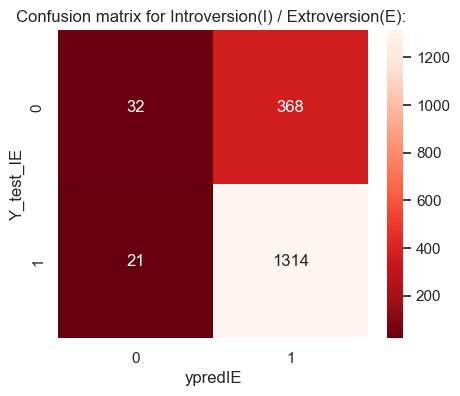

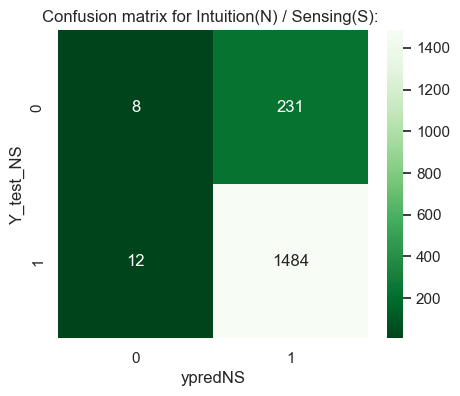

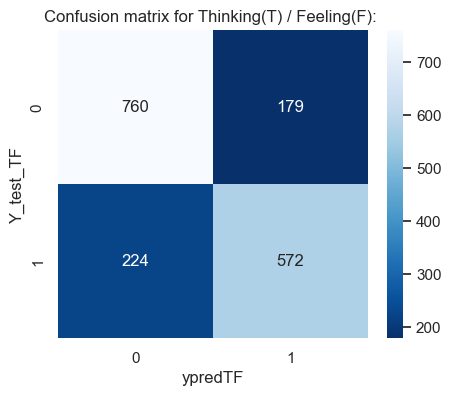

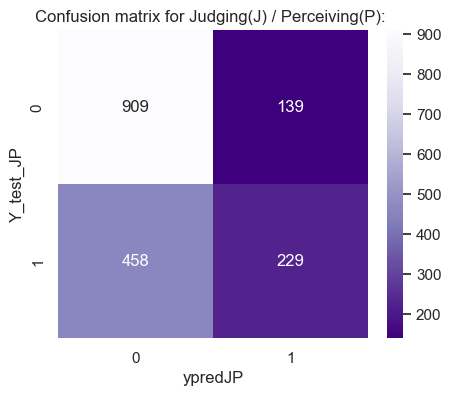

In [77]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

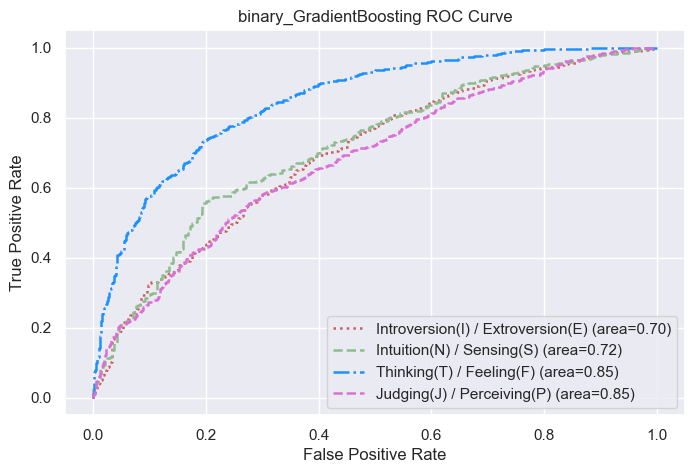

In [78]:
# ROC Curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF), grid4.best_estimator_.predict_proba(X_test_JP),
                    title='binary_GradientBoosting')

### Oversampled data

#### Naive Bayes Model

In [ ]:
gNB = GaussianNB()
# Cross validation
grid1 = GridSearchCV(gNB,{},cv=5)
grid2 = GridSearchCV(gNB,{},cv=5)
grid3 = GridSearchCV(gNB,{},cv=5)
grid4 = GridSearchCV(gNB,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict_SMOTE(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.24      0.38      0.29       400
           1       0.77      0.63      0.70      1335

    accuracy                           0.57      1735
   macro avg       0.51      0.51      0.49      1735
weighted avg       0.65      0.57      0.60      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.16      0.38      0.22       239
           1       0.87      0.68      0.76      1496

    accuracy                           0.63      1735
   macro avg       0.51      0.53      0.49      1735
weighted avg       0.77      0.63      0.69      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.72      0.58      0.65       939
           1       0.60      0.74      0.66       796

    accuracy

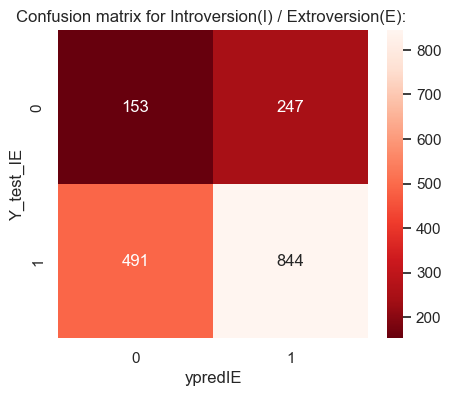

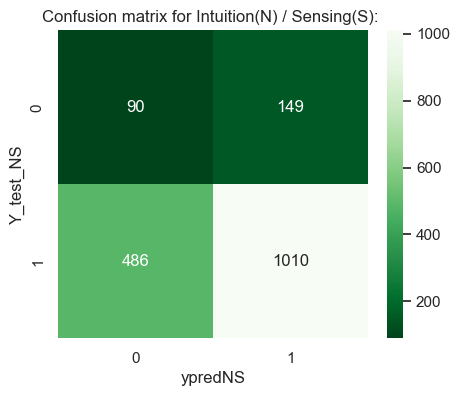

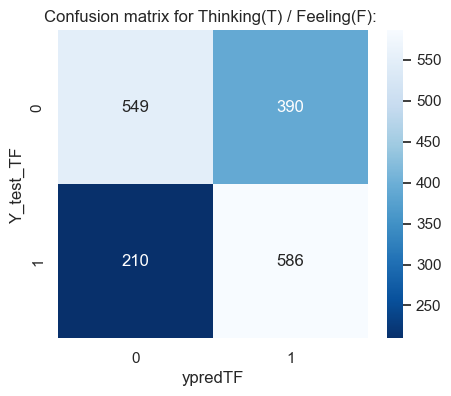

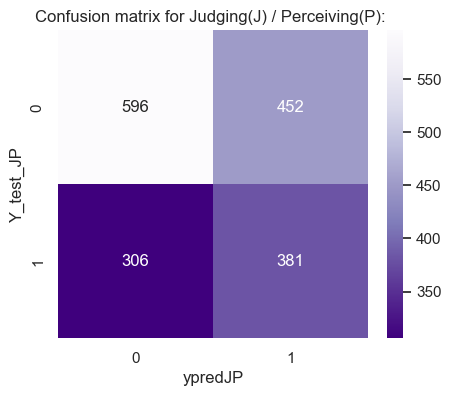

In [ ]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

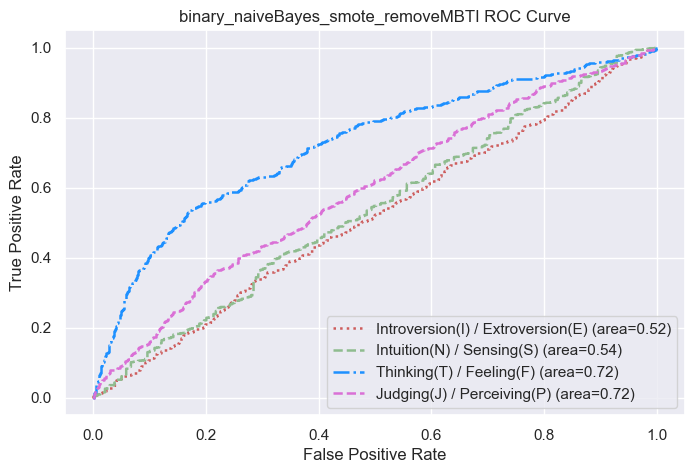

In [ ]:
# ROC Curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF), grid4.best_estimator_.predict_proba(X_test_JP),
                    title='binary_NaiveBayes_smote')

#### Logistic Regression

In [ ]:
log = LogisticRegression(max_iter=500)
# Cross validation
grid1 = GridSearchCV(log,{},cv=5)
grid2 = GridSearchCV(log,{},cv=5)
grid3 = GridSearchCV(log,{},cv=5)
grid4 = GridSearchCV(log,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict_SMOTE(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.39      0.64      0.49       400
           1       0.87      0.70      0.78      1335

    accuracy                           0.69      1735
   macro avg       0.63      0.67      0.63      1735
weighted avg       0.76      0.69      0.71      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.28      0.73      0.41       239
           1       0.94      0.70      0.80      1496

    accuracy                           0.71      1735
   macro avg       0.61      0.72      0.61      1735
weighted avg       0.85      0.71      0.75      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.84      0.77      0.81       939
           1       0.76      0.83      0.79       796

    accuracy

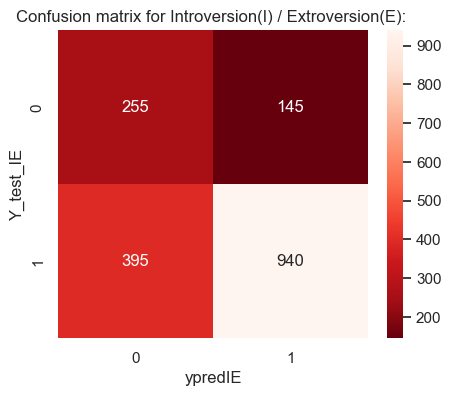

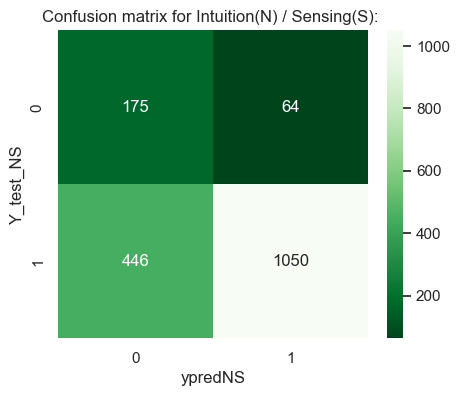

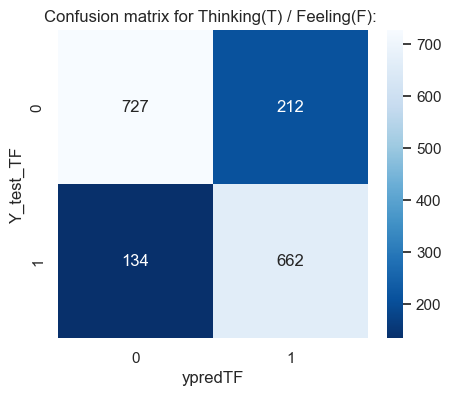

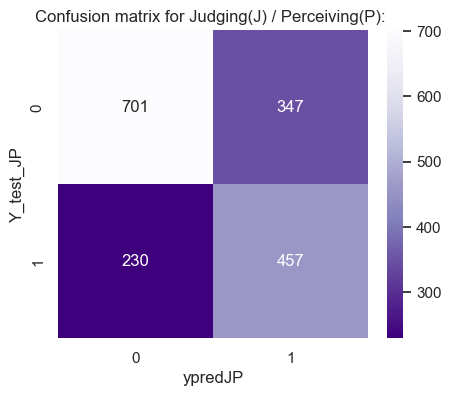

In [ ]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

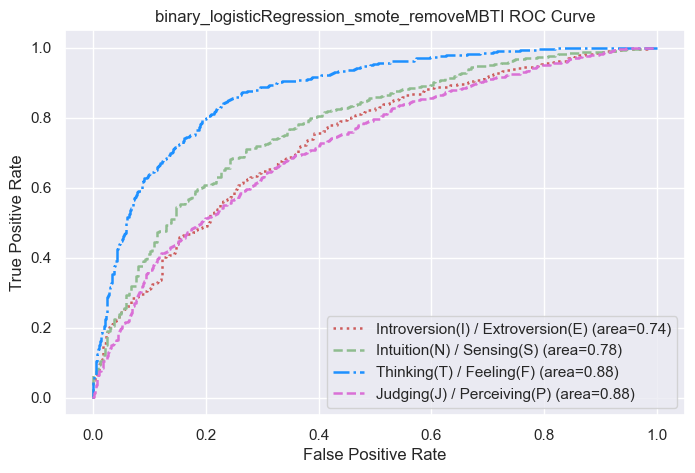

In [ ]:
# ROC curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF),grid4.best_estimator_.predict_proba(X_test_JP),
                    title='binary_LogisticRegression_smote')

#### SVM

In [ ]:
svm = SVC(random_state=42, probability=True)
# {} = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}
# Cross validation
grid1 = GridSearchCV(svm,{},cv=5)
grid2 = GridSearchCV(svm,{},cv=5)
grid3 = GridSearchCV(svm,{},cv=5)
grid4 = GridSearchCV(svm,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict_SMOTE(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.42      0.50      0.46       400
           1       0.84      0.80      0.82      1335

    accuracy                           0.73      1735
   macro avg       0.63      0.65      0.64      1735
weighted avg       0.74      0.73      0.74      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.33      0.48      0.39       239
           1       0.91      0.84      0.88      1496

    accuracy                           0.79      1735
   macro avg       0.62      0.66      0.63      1735
weighted avg       0.83      0.79      0.81      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       939
           1       0.76      0.79      0.78       796

    accuracy

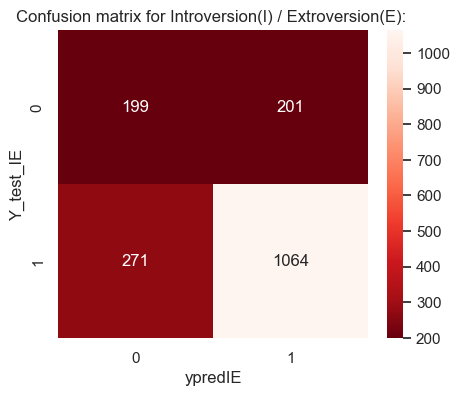

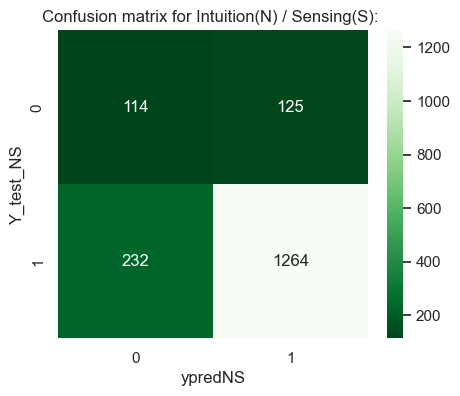

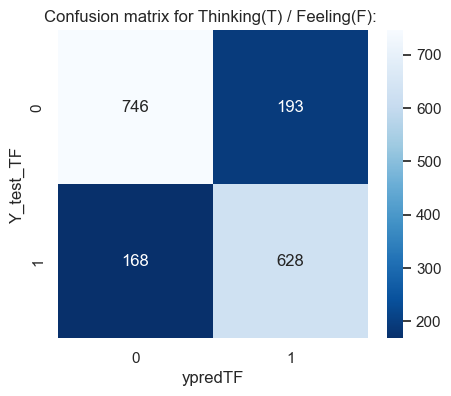

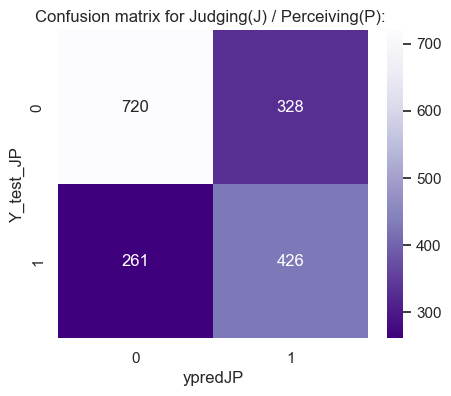

In [ ]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

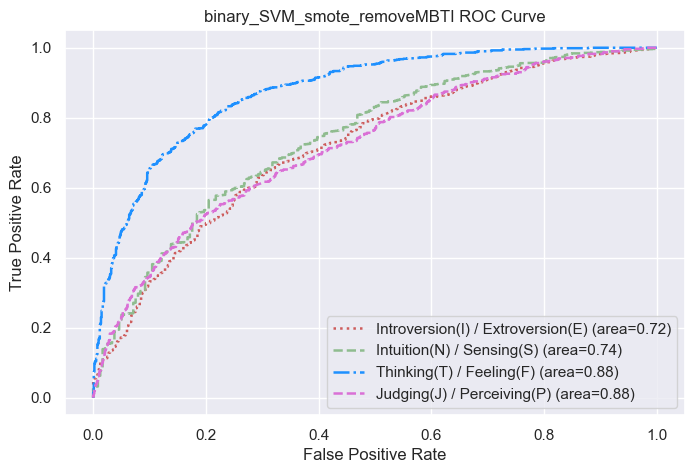

In [ ]:
# ROC curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF),grid4.best_estimator_.predict_proba(X_test_JP),
                    title='binary_SVM_smote')

#### K-Nearest Neighbor (KNN)

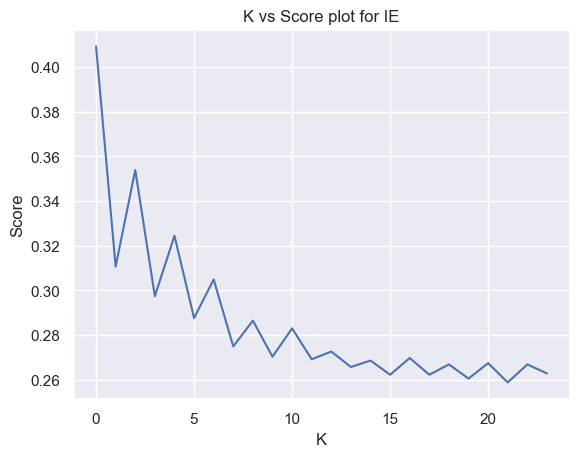

Maximum Accuracy of 0.4092219020172911 at k=1


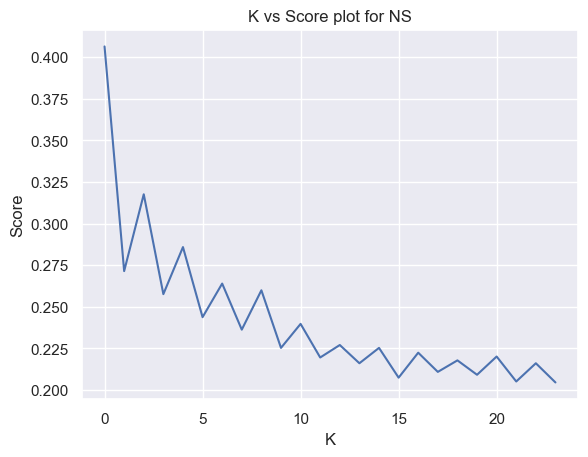

Maximum Accuracy of 0.40634005763688763 at k=1


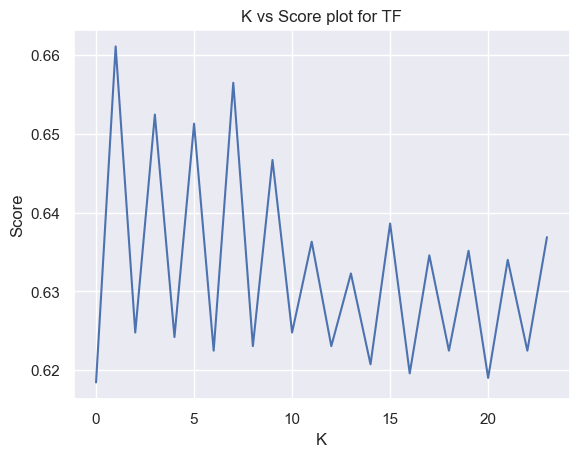

Maximum Accuracy of 0.6610951008645534 at k=2


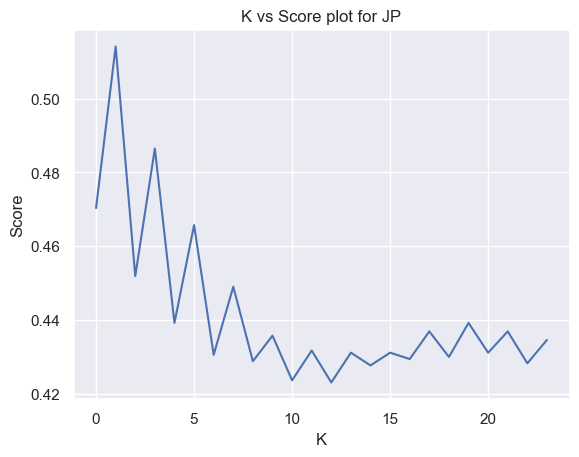

Maximum Accuracy of 0.6610951008645534 at k=2


In [ ]:
def plot_graph(val,xlab,ylab,title):
    plt.figure()
    plt.plot(val)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,25):
    k1 = KNeighborsClassifier(n_neighbors=i)
    k1.fit(X_smote_IE, Y_smote_IE)
    k1_score.append(k1.score(X_test_IE, Y_test_IE))

df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'K','Score','K vs Score plot for IE')
print(f'Maximum Accuracy of {df1.max()[0]} at k={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,25):
	k2 = KNeighborsClassifier(n_neighbors=i)
	k2.fit(X_smote_NS, Y_smote_NS)
	k2_score.append(k2.score(X_test_NS, Y_test_NS))

df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'K','Score','K vs Score plot for NS')
print(f'Maximum Accuracy of {df2.max()[0]} at k={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,25):
  k3 = KNeighborsClassifier(n_neighbors=i)
  k3.fit(X_smote_TF, Y_smote_TF)
  k3_score.append(k3.score(X_test_TF, Y_test_TF))

df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'K','Score','K vs Score plot for TF')
print(f'Maximum Accuracy of {df3.max()[0]} at k={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,25):
  k4 = KNeighborsClassifier(n_neighbors=i)
  k4.fit(X_smote_JP, Y_smote_JP)
  k4_score.append(k4.score(X_test_JP, Y_test_JP))

df4 = pd.DataFrame(k3_score,columns=['JP'])
plot_graph(k4_score,'K','Score','K vs Score plot for JP')
print(f'Maximum Accuracy of {df4.max()[0]} at k={df4.idxmax()[0]+1}')

In [ ]:
kbest = KNeighborsClassifier(n_neighbors=df1.idxmax()[0]+1)
ypredIE = kbest.fit(X_smote_IE,Y_smote_IE).predict(X_test_IE)
probIE = kbest.predict_proba(X_test_IE)

kbest = KNeighborsClassifier(n_neighbors=df2.idxmax()[0]+1)
ypredNS = kbest.fit(X_smote_NS,Y_smote_NS).predict(X_test_NS)
probNS = kbest.predict_proba(X_test_NS)

kbest = KNeighborsClassifier(n_neighbors=df3.idxmax()[0]+1)
ypredTF = kbest.fit(X_smote_TF,Y_smote_TF).predict(X_test_TF)
probTF = kbest.predict_proba(X_test_TF)

kbest = KNeighborsClassifier(n_neighbors=df4.idxmax()[0]+1)
ypredJP = kbest.fit(X_smote_JP,Y_smote_JP).predict(X_test_JP)
probJP = kbest.predict_proba(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.25      0.79      0.38       400
           1       0.82      0.30      0.44      1335

    accuracy                           0.41      1735
   macro avg       0.54      0.54      0.41      1735
weighted avg       0.69      0.41      0.42      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.16      0.75      0.26       239
           1       0.90      0.35      0.50      1496

    accuracy                           0.41      1735
   macro avg       0.53      0.55      0.38      1735
weighted avg       0.80      0.41      0.47      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       939
           1       0.62      0.66      0.64       796

    accuracy

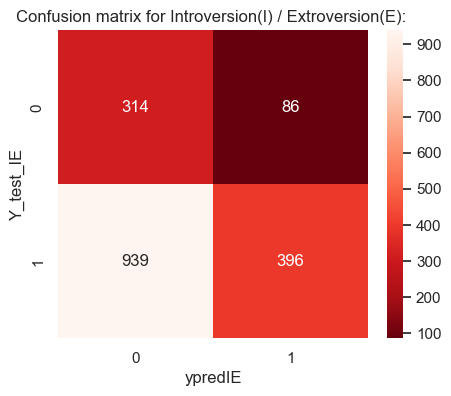

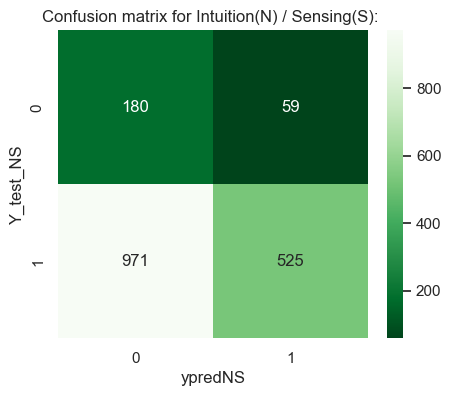

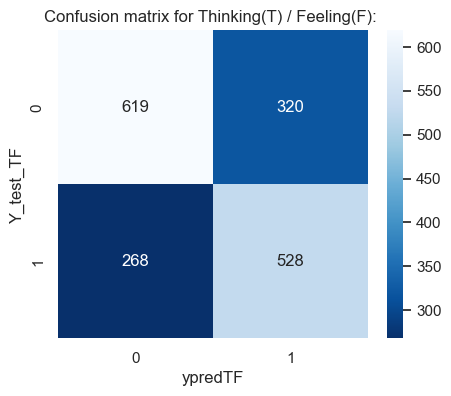

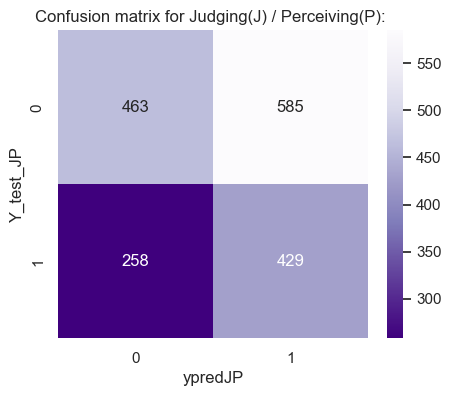

In [ ]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

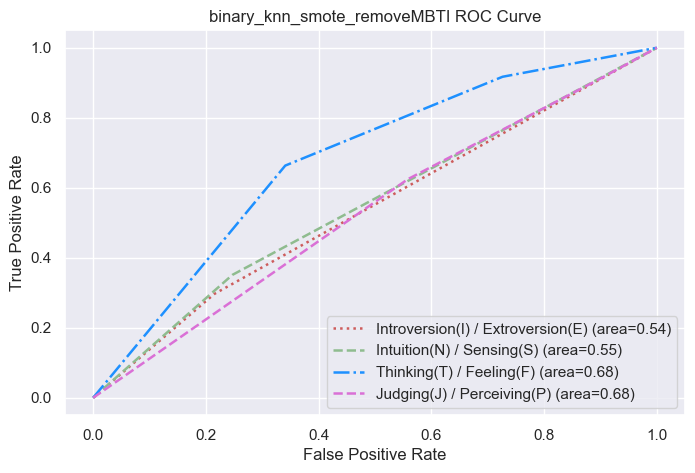

In [ ]:
# ROC curve
print_roc_auc_curve(probIE, probNS, probTF, probJP, title='binary_KNN_smote')

#### Decision Tree

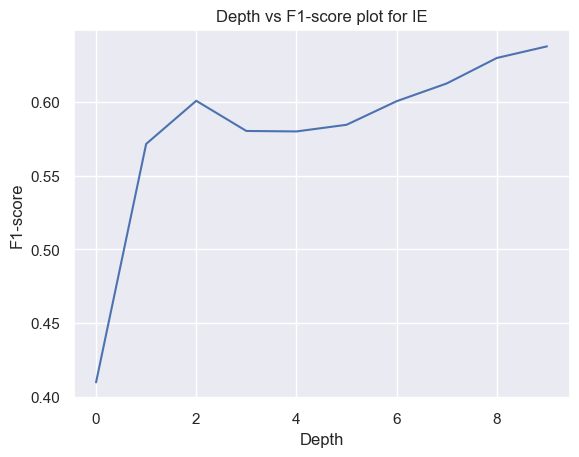

Maximum F1-score of 0.637724895899337 at depth=10


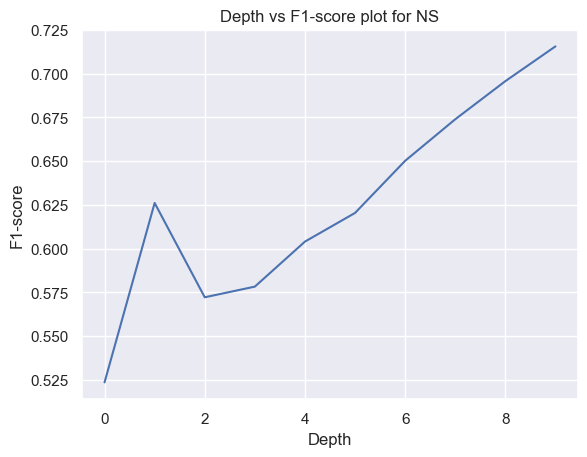

Maximum F1-score of 0.7156278109357977 at depth=10


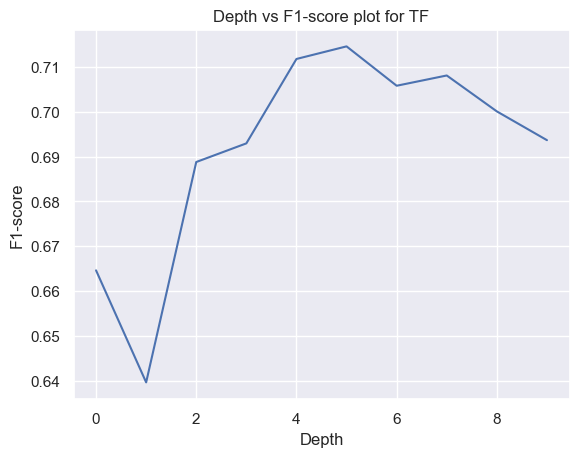

Maximum F1-score of 0.7145837087454983 at depth=6


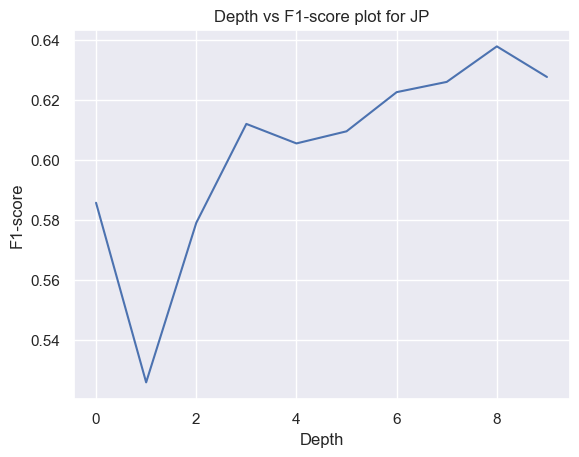

Maximum F1-score of 0.6377422352303598 at depth=9


In [ ]:
def plot_graph(val, title):
    plt.plot(val)
    plt.ylabel('F1-score')
    plt.xlabel('Depth')
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,11):
    k1_cart = DecisionTreeClassifier(criterion="gini", max_depth=i)
    score = cross_val_score(k1_cart, X_smote_IE, Y_smote_IE, cv=5, scoring='f1')
    k1_score.append(score.mean())
df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'Depth vs F1-score plot for IE')
print(f'Maximum F1-score of {df1.max()[0]} at depth={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,11):
    k2_cart = DecisionTreeClassifier(criterion="gini", max_depth=i)
    score = cross_val_score(k2_cart, X_smote_NS, Y_smote_NS, cv=5, scoring='f1')
    k2_score.append(score.mean())
df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'Depth vs F1-score plot for NS')
print(f'Maximum F1-score of {df2.max()[0]} at depth={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,11):
    k3_cart = DecisionTreeClassifier(criterion="gini", max_depth=i)
    score = cross_val_score(k3_cart, X_smote_TF, Y_smote_TF, cv=5, scoring='f1')
    k3_score.append(score.mean())
df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'Depth vs F1-score plot for TF')
print(f'Maximum F1-score of {df3.max()[0]} at depth={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,11):
    k4_cart = DecisionTreeClassifier(criterion="gini", max_depth=i)
    score = cross_val_score(k4_cart, X_smote_JP, Y_smote_JP, cv=5, scoring='f1')
    k4_score.append(score.mean())
df4 = pd.DataFrame(k4_score,columns=['JP'])
plot_graph(k4_score,'Depth vs F1-score plot for JP')
print(f'Maximum F1-score of {df4.max()[0]} at depth={df4.idxmax()[0]+1}')

In [ ]:
dtbest = DecisionTreeClassifier(criterion="gini", max_depth=df1.idxmax()[0]+1)
ypredIE = dtbest.fit(X_smote_IE,Y_smote_IE).predict(X_test_IE)
probIE = dtbest.predict_proba(X_test_IE)

dtbest = DecisionTreeClassifier(criterion="gini", max_depth=df2.idxmax()[0]+1)
ypredNS = dtbest.fit(X_smote_NS,Y_smote_NS).predict(X_test_NS)
probNS = dtbest.predict_proba(X_test_NS)

dtbest = DecisionTreeClassifier(criterion="gini", max_depth=df3.idxmax()[0]+1)
ypredTF = dtbest.fit(X_smote_TF,Y_smote_TF).predict(X_test_TF)
probTF = dtbest.predict_proba(X_test_TF)

dtbest = DecisionTreeClassifier(criterion="gini", max_depth=df4.idxmax()[0]+1)
ypredJP = dtbest.fit(X_smote_JP,Y_smote_JP).predict(X_test_JP)
probJP = dtbest.predict_proba(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.29      0.57      0.39       400
           1       0.82      0.58      0.68      1335

    accuracy                           0.58      1735
   macro avg       0.56      0.58      0.53      1735
weighted avg       0.70      0.58      0.61      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.19      0.54      0.28       239
           1       0.90      0.63      0.74      1496

    accuracy                           0.61      1735
   macro avg       0.54      0.59      0.51      1735
weighted avg       0.80      0.61      0.67      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       939
           1       0.63      0.73      0.68       796

    accuracy

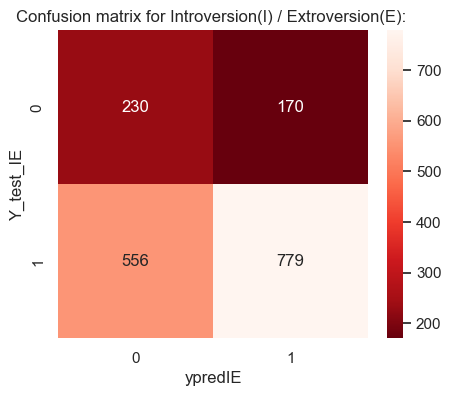

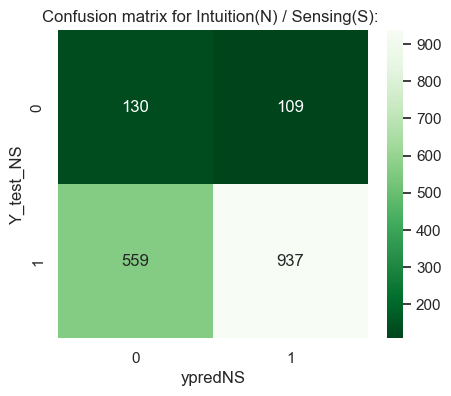

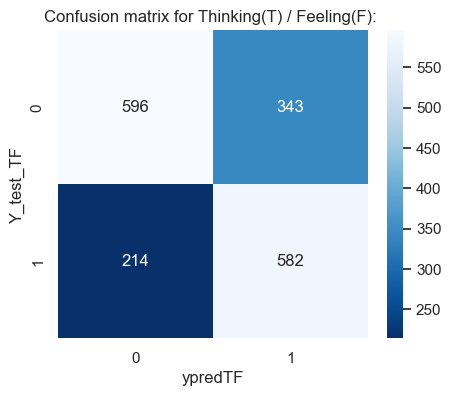

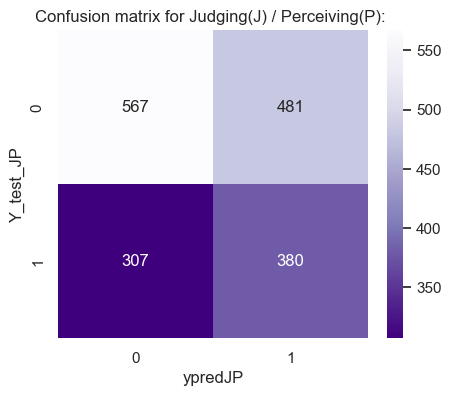

In [ ]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

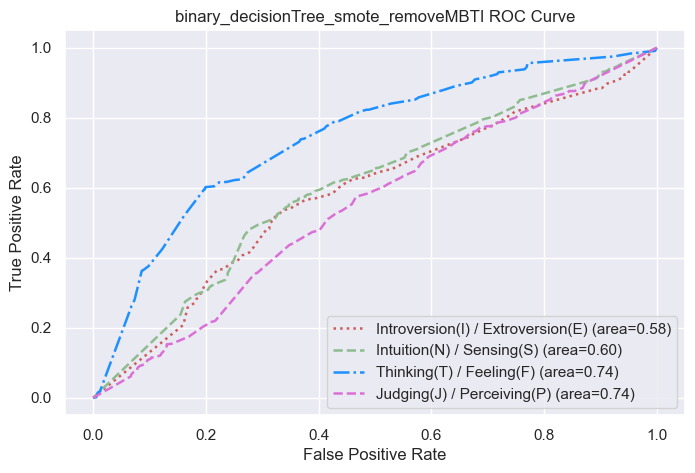

In [ ]:
# ROC curve
print_roc_auc_curve(probIE, probNS, probTF, probJP, title='binary_DecisionTree_smote')

#### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators = 100,  # amount of decision tree
                            random_state = 42)
# Cross validation
grid1 = GridSearchCV(rf,{},cv=5)
grid2 = GridSearchCV(rf,{},cv=5)
grid3 = GridSearchCV(rf,{},cv=5)
grid4 = GridSearchCV(rf,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict_SMOTE(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.38      0.18      0.24       400
           1       0.79      0.91      0.85      1335

    accuracy                           0.74      1735
   macro avg       0.58      0.55      0.55      1735
weighted avg       0.69      0.74      0.71      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.33      0.12      0.17       239
           1       0.87      0.96      0.91      1496

    accuracy                           0.84      1735
   macro avg       0.60      0.54      0.54      1735
weighted avg       0.80      0.84      0.81      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       939
           1       0.74      0.69      0.72       796

    accuracy

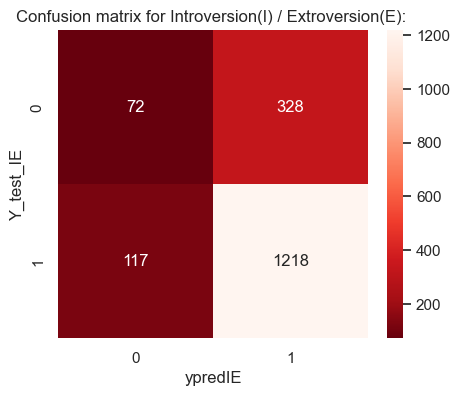

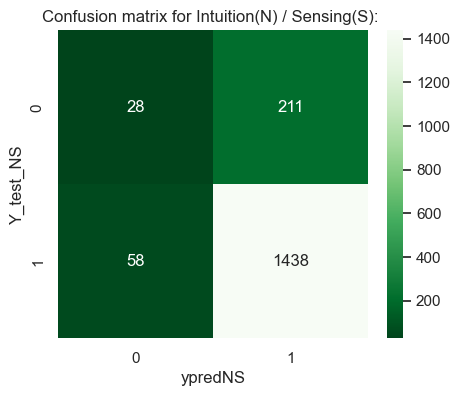

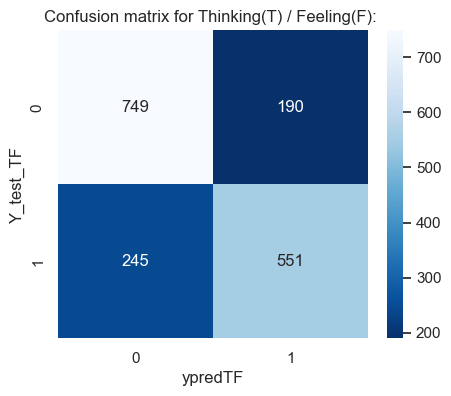

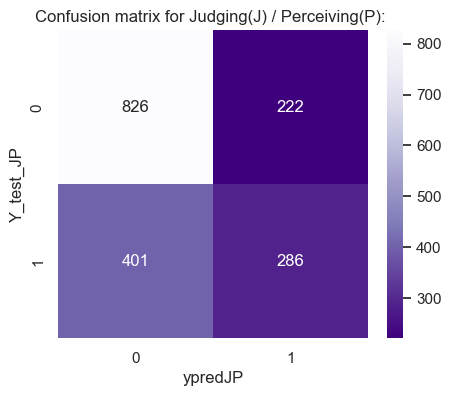

In [ ]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

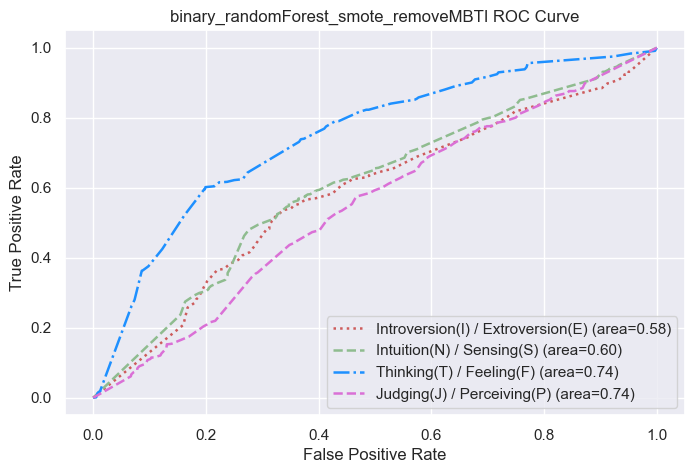

In [ ]:
# ROC curve
print_roc_auc_curve(probIE, probNS, probTF, probJP, title='binary_RandomForest_smote')

#### GradientBoost

In [ ]:
boost = GradientBoostingClassifier(random_state=42)
# Cross validation
grid1 = GridSearchCV(boost,{},cv=5)
grid2 = GridSearchCV(boost,{},cv=5)
grid3 = GridSearchCV(boost,{},cv=5)
grid4 = GridSearchCV(boost,{},cv=5)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predict_SMOTE(grid1, grid2, grid3, grid4)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.36      0.47      0.41       400
           1       0.83      0.75      0.79      1335

    accuracy                           0.69      1735
   macro avg       0.59      0.61      0.60      1735
weighted avg       0.72      0.69      0.70      1735


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.25      0.43      0.31       239
           1       0.90      0.79      0.84      1496

    accuracy                           0.74      1735
   macro avg       0.57      0.61      0.58      1735
weighted avg       0.81      0.74      0.77      1735


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       939
           1       0.75      0.78      0.76       796

    accuracy

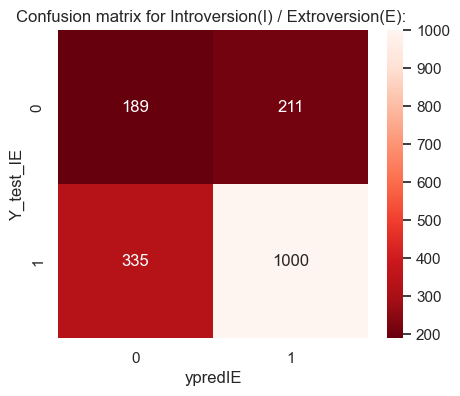

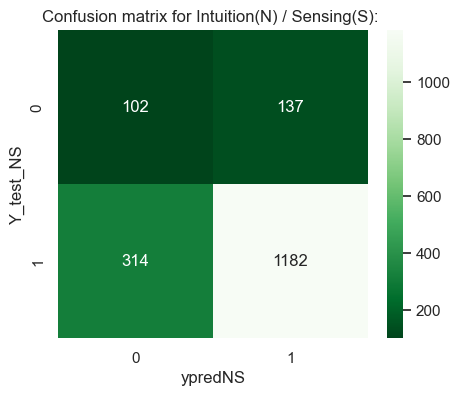

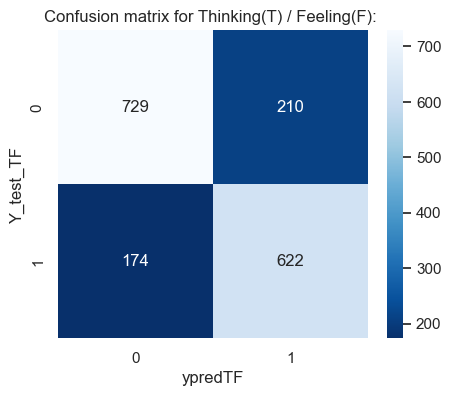

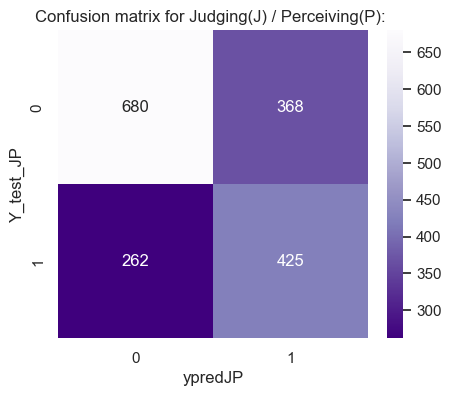

In [ ]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

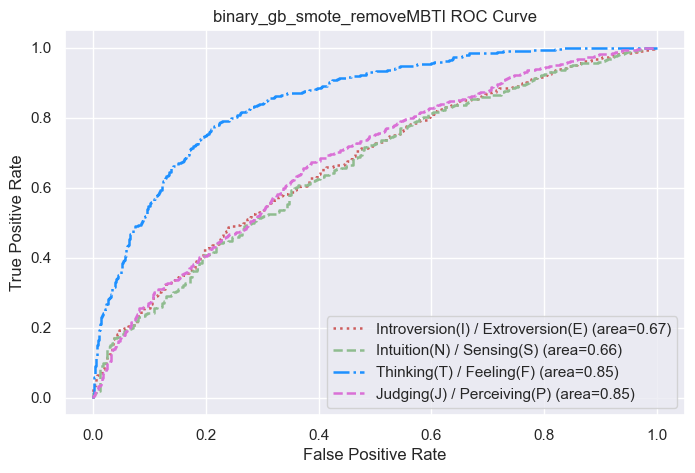

In [ ]:
# ROC Curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF), grid4.best_estimator_.predict_proba(X_test_JP),
                    title='binary_GradientBoosting_smote')